In [1]:
# 1. Install dependencies
!pip install -q kaggle librosa tensorflow

In [2]:
# 2. Set up Kaggle API (upload your kaggle.json when prompted)
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# 3. Download dataset (example - replace with your dataset)
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import librosa
import librosa.display

In [6]:
# to play the audio files
from IPython.display import Audio

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

In [9]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

In [10]:
Crema_path = "/content/Crema/"
Ravdess_path = "/content/Ravdess/audio_speech_actors_01-24/"
Savee_path = "/content/Savee"
Tess_path = "/content/Tess/"

In [11]:
Crema_dir_list = os.listdir(Crema_path)
Ravdess_dir_list = os.listdir(Ravdess_path)
Savee_dir_list = os.listdir(Savee_path)
Tess_dir_list = os.listdir(Tess_path)

In [12]:
Ex_Crema_dir_list = Crema_dir_list[:15]
Ex_Crema_dir_list

['1077_IEO_ANG_MD.wav',
 '1080_IEO_SAD_LO.wav',
 '1009_DFA_FEA_XX.wav',
 '1075_TAI_DIS_XX.wav',
 '1070_DFA_FEA_XX.wav',
 '1065_TSI_FEA_XX.wav',
 '1070_TIE_FEA_XX.wav',
 '1031_IWL_SAD_XX.wav',
 '1028_IEO_FEA_LO.wav',
 '1043_WSI_DIS_XX.wav',
 '1088_IWW_HAP_XX.wav',
 '1031_IEO_SAD_LO.wav',
 '1070_ITH_FEA_XX.wav',
 '1074_IWW_DIS_XX.wav',
 '1017_MTI_NEU_XX.wav']

In [13]:
emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # storing file paths
    paths_crema.append(Crema_path + it)
    # storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')

# dataframe for emotion of files
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

# dataframe for path of files.
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(Crema_df.shape)
Crema_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

(7442, 2)


In [14]:
[Crema_df["Emotions"].unique().tolist() for i in Crema_df.columns]

[['angry', 'sad', 'fear', 'disgust', 'happy', 'neutral'],
 ['angry', 'sad', 'fear', 'disgust', 'happy', 'neutral']]

In [15]:
font1 = {'family':'Times New Roman','color':'blue','size':30}
font2 = {'family':'Times New Roman','color':'blue','size':20}
font3 = {'family':'Times New Roman','color':'blue','size':10}

In [89]:
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'

# Add the font to the font manager
fm.fontManager.addfont(font_path)

# Now you can use the font
plt.rcParams['font.family'] = 'Times New Roman'

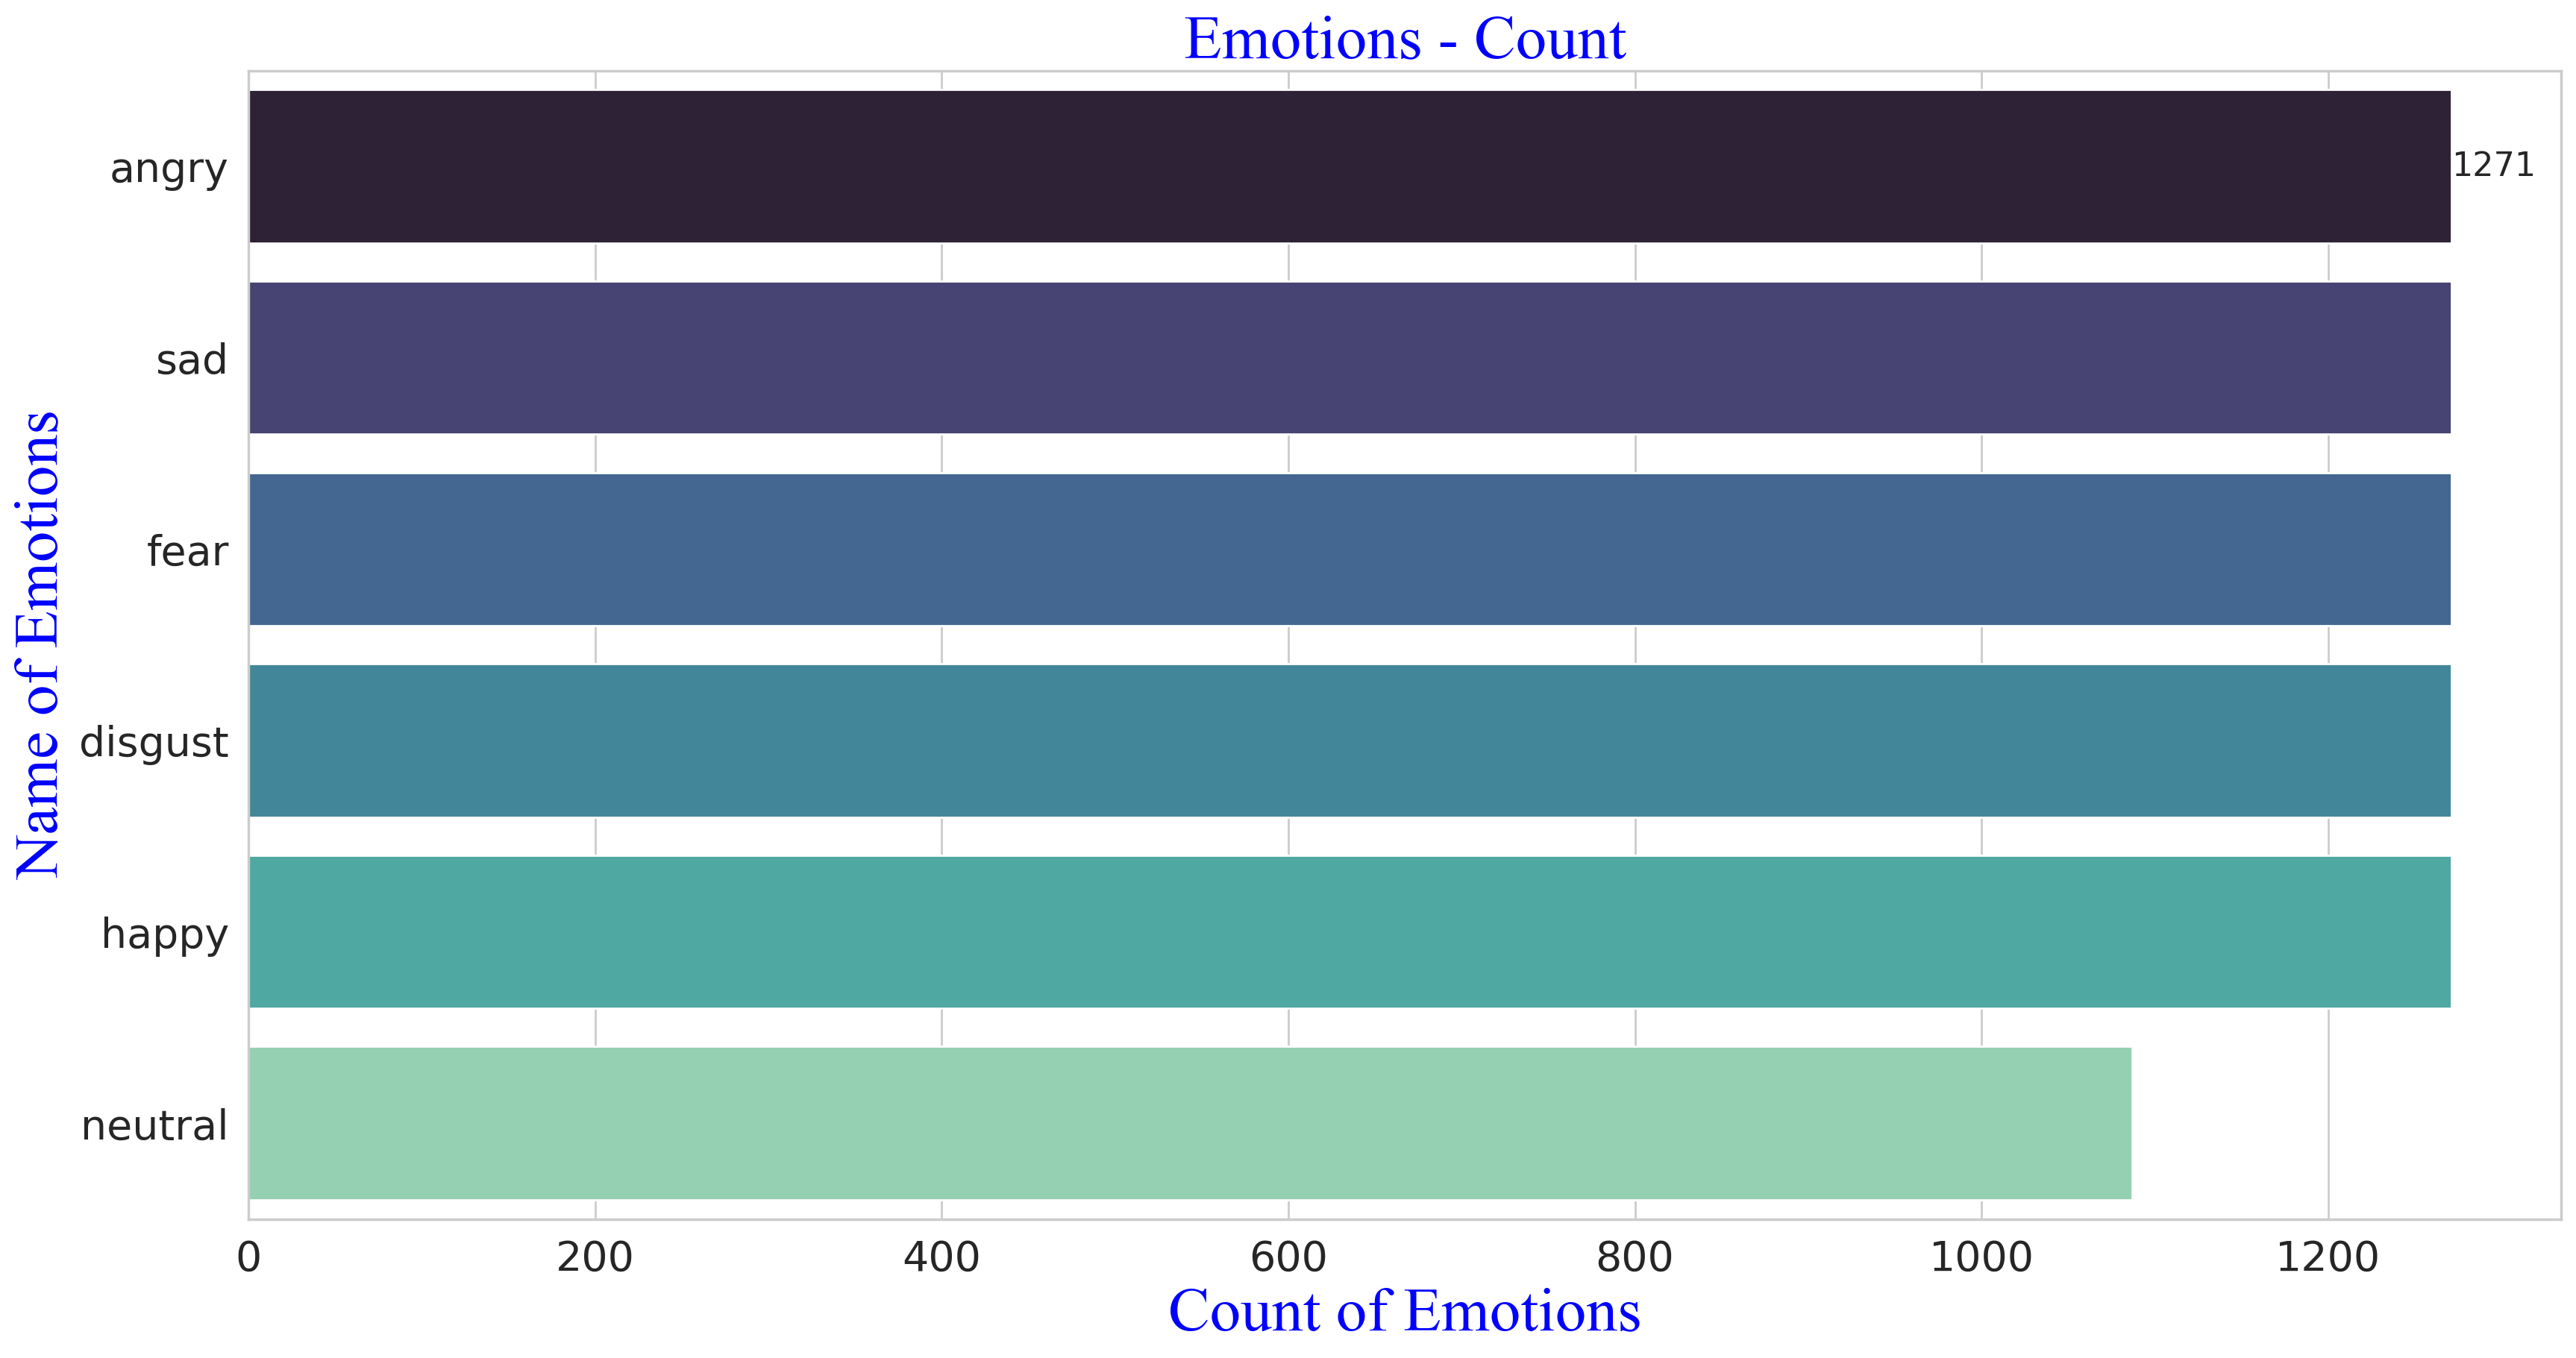

In [90]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Crema_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [17]:
Ex_Ravdess_dir_list = Ravdess_dir_list[:15]
Ex_Ravdess_dir_list

['Actor_06',
 'Actor_04',
 'Actor_21',
 'Actor_11',
 'Actor_07',
 'Actor_15',
 'Actor_09',
 'Actor_14',
 'Actor_12',
 'Actor_02',
 'Actor_03',
 'Actor_17',
 'Actor_01',
 'Actor_08',
 'Actor_05']

In [18]:
emotions_ravdess = []
path_ravdess = []

for it in Ravdess_dir_list:
    # There are 20 actors
    actor = os.listdir(Ravdess_path + it)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        emotions_ravdess.append(int(part[2]))
        path_ravdess.append(Ravdess_path + it + '/' + file)


emotion_ravdess_df = pd.DataFrame(emotions_ravdess, columns=['Emotions'])

path_ravdess_df = pd.DataFrame(path_ravdess, columns=['Path'])
Ravdess_df = pd.concat([emotion_ravdess_df, path_ravdess_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm',
                             3:'happy', 4:'sad', 5:'angry',
                             6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [19]:
[Ravdess_df["Emotions"].unique().tolist() for i in Ravdess_df.columns]

[['calm', 'surprise', 'angry', 'happy', 'disgust', 'sad', 'fear', 'neutral'],
 ['calm', 'surprise', 'angry', 'happy', 'disgust', 'sad', 'fear', 'neutral']]

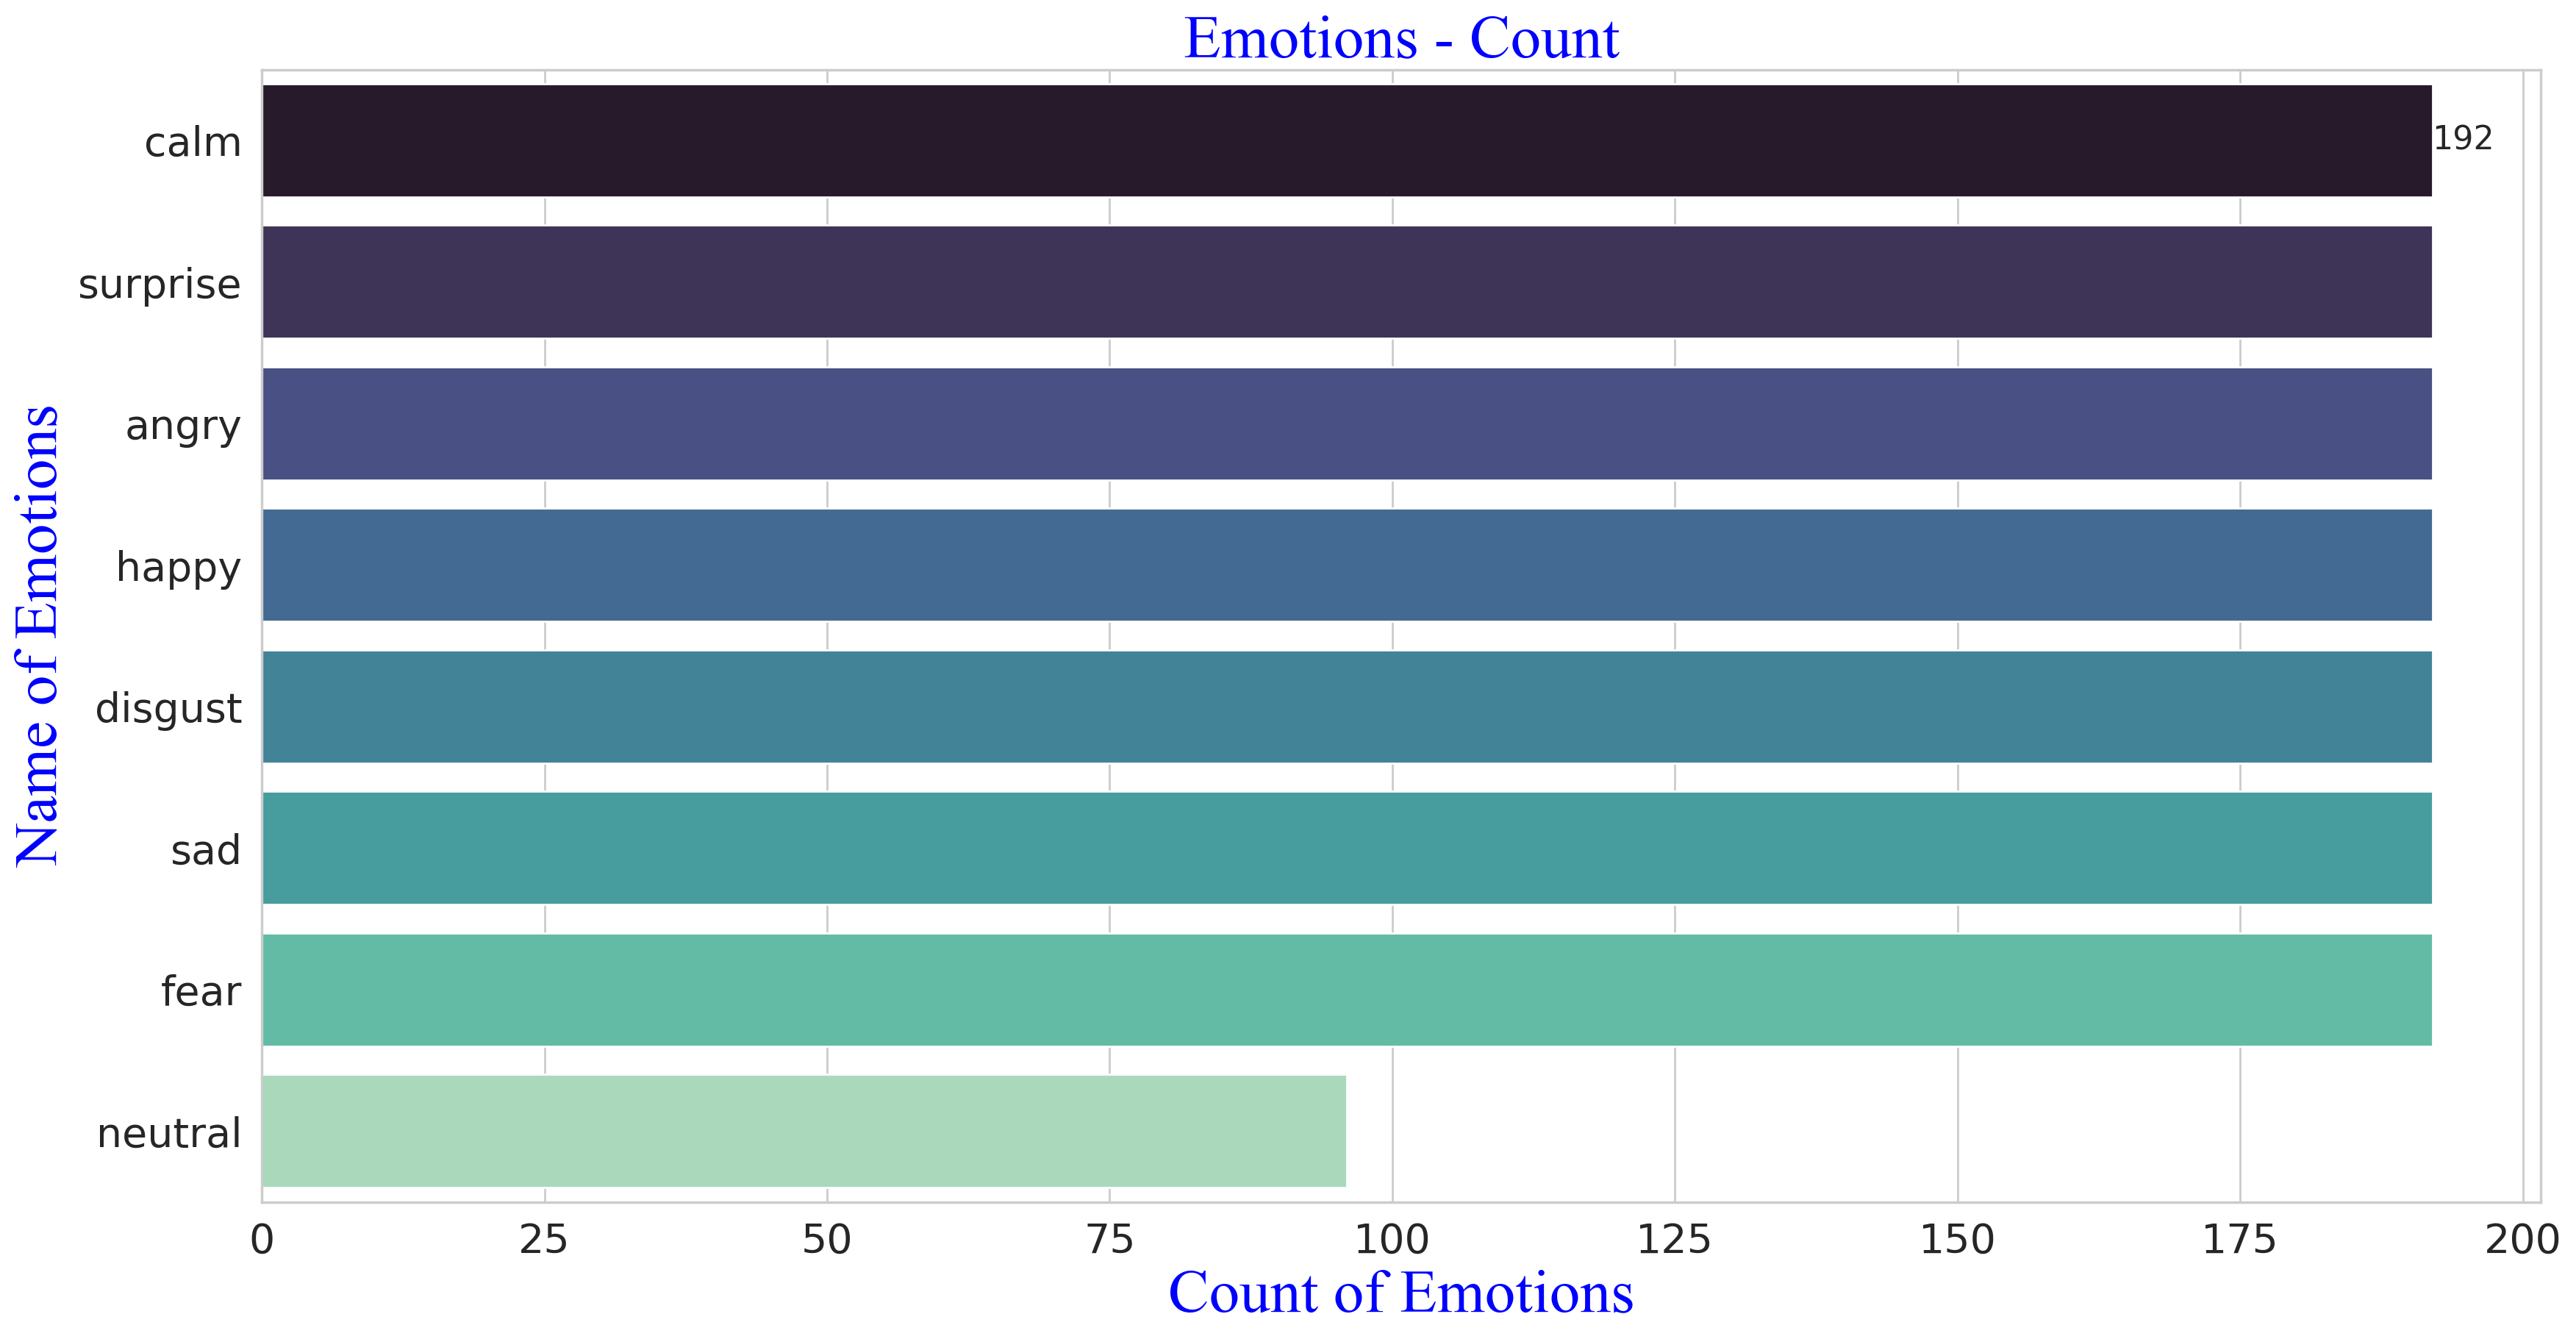

In [91]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Ravdess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [21]:
Ex_Savee_dir_list = Savee_dir_list[:15]
Ex_Savee_dir_list

['DC_d03.wav',
 'JK_a02.wav',
 'JE_f10.wav',
 'KL_a02.wav',
 'JK_h15.wav',
 'DC_a06.wav',
 'DC_h08.wav',
 'KL_n28.wav',
 'KL_a03.wav',
 'KL_d09.wav',
 'JK_su08.wav',
 'JE_n19.wav',
 'JE_n04.wav',
 'KL_sa04.wav',
 'KL_d14.wav']

In [22]:
emotions_savee = []
path_savee = []

for it in Savee_dir_list:
    path_savee.append(Savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('angry')
    elif part == 'd':
        emotions_savee.append('disgust')
    elif part == 'f':
        emotions_savee.append('fear')
    elif part == 'h':
        emotions_savee.append('happiness')
    elif part == 'n':
        emotions_savee.append('neutral')
    elif part == 'sa':
        emotions_savee.append('sadness')
    elif part == 'su':
        emotions_savee.append('surprise')

    else:
        emotions_savee.append('Unknown')

# dataframe for emotion of files
emotion_savee_df = pd.DataFrame(emotions_savee, columns=['Emotions'])

# dataframe for path of files.
path_savee_df = pd.DataFrame(path_savee, columns=['Path'])
Savee_df = pd.concat([emotion_savee_df, path_savee_df], axis=1)
Savee_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [23]:
[Savee_df["Emotions"].unique().tolist() for i in Savee_df.columns]

[['disgust', 'angry', 'fear', 'happiness', 'neutral', 'surprise', 'sadness'],
 ['disgust', 'angry', 'fear', 'happiness', 'neutral', 'surprise', 'sadness']]

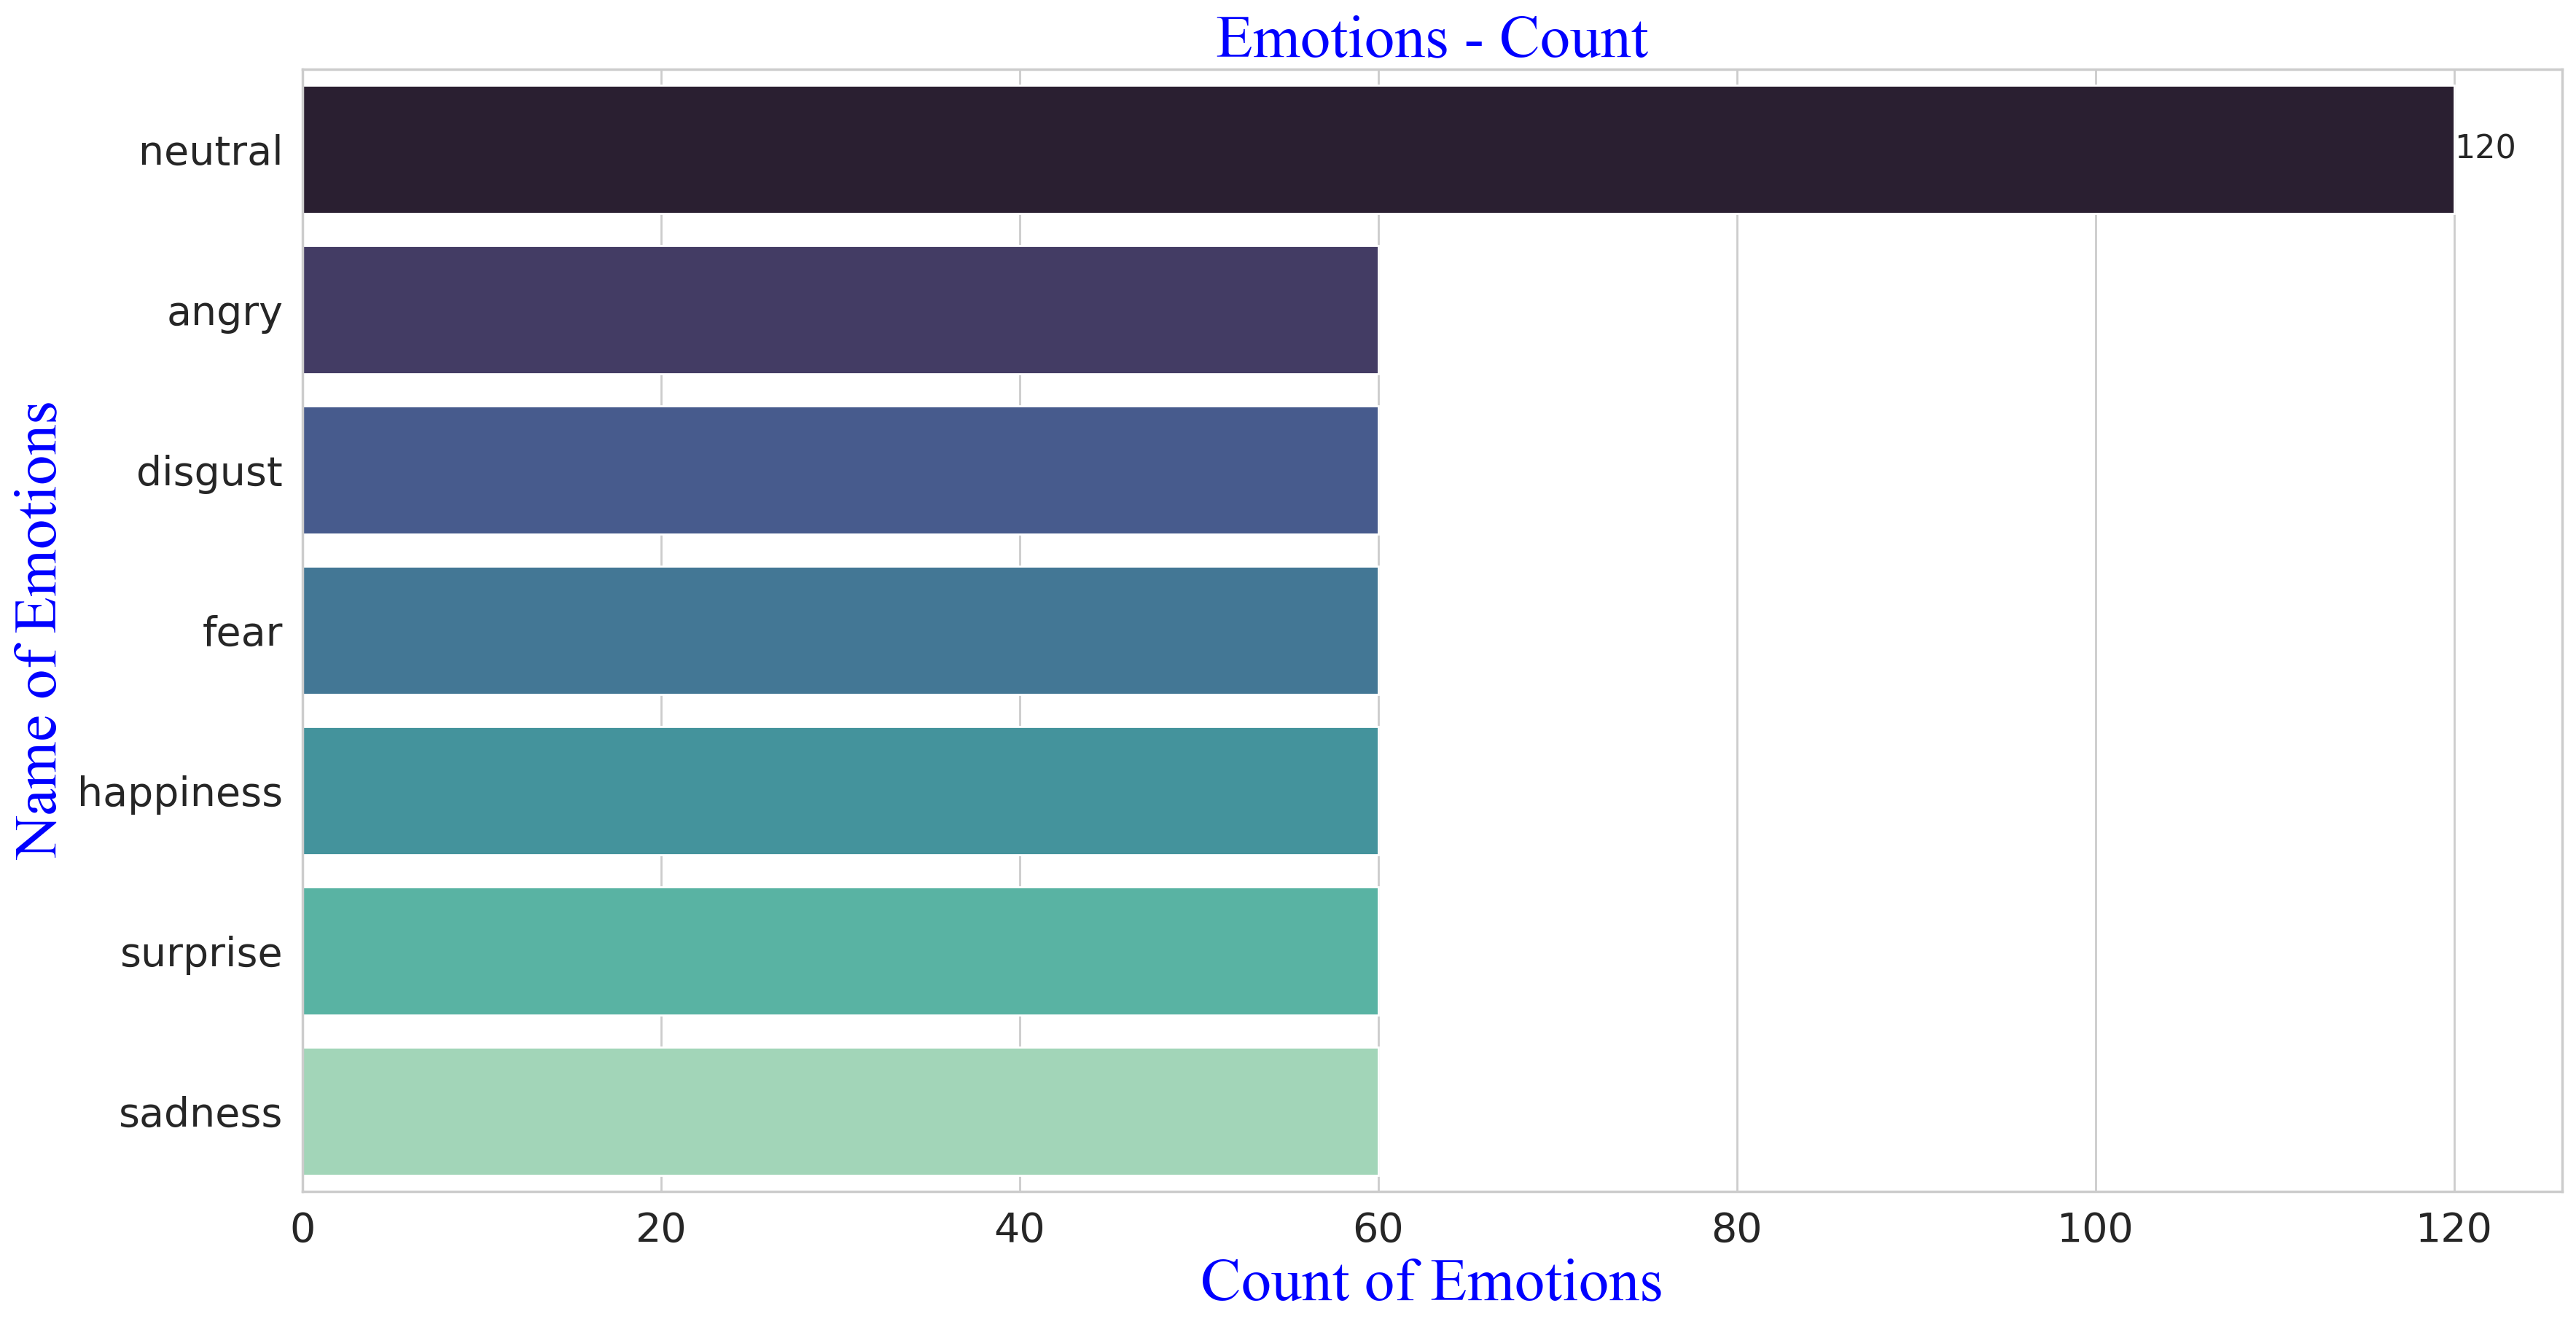

In [92]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Savee_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [25]:
Ex_Tess_dir_list = Tess_dir_list[:15]
Ex_Tess_dir_list

['OAF_angry',
 'YAF_pleasant_surprised',
 'OAF_Pleasant_surprise',
 'YAF_neutral',
 'YAF_angry',
 'OAF_neutral',
 'OAF_disgust',
 'OAF_Sad',
 'YAF_fear',
 'YAF_happy',
 'YAF_disgust',
 'OAF_happy',
 'YAF_sad',
 'OAF_Fear']

In [27]:
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)



# dataframe for emotion of files
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])

# dataframe for path of files.
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)
Tess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [28]:
[Tess_df["Emotions"].unique().tolist() for i in Tess_df.columns]

[['angry', 'surprise', 'neutral', 'disgust', 'sad', 'fear', 'happy'],
 ['angry', 'surprise', 'neutral', 'disgust', 'sad', 'fear', 'happy']]

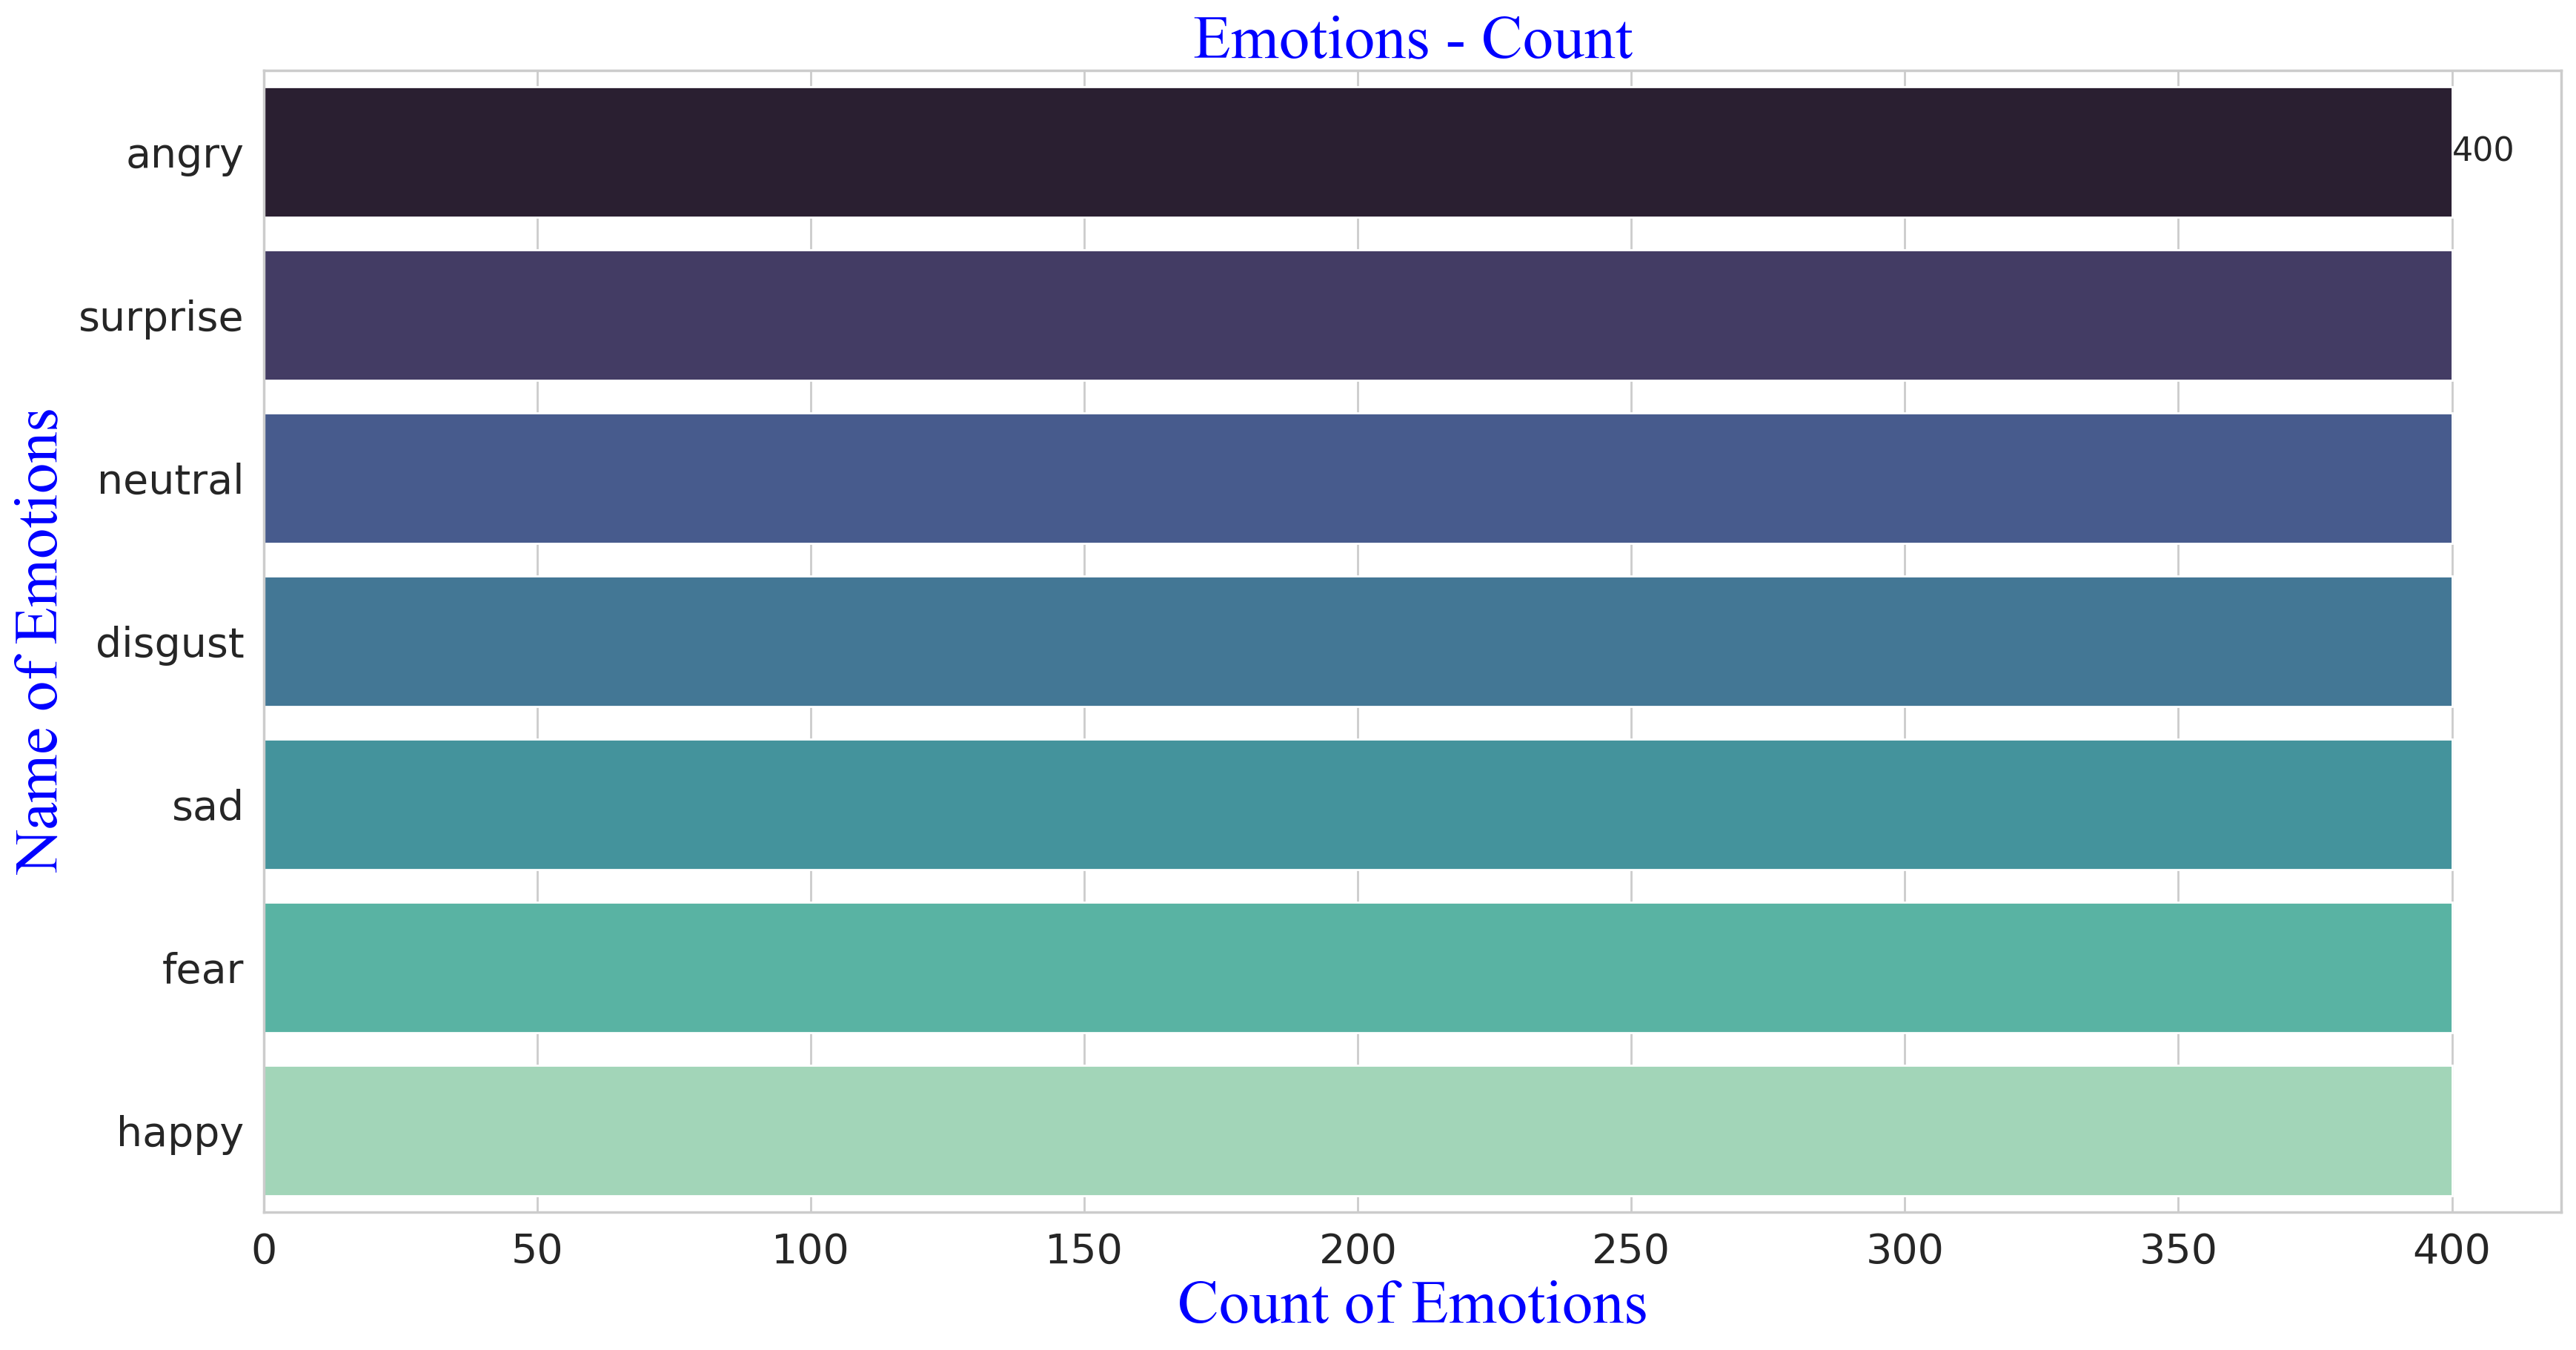

In [93]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Tess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [30]:
Sum_df = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis = 0)
Sum_df.to_csv("Sum_df.csv",index=False)
Sum_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

In [31]:
[Sum_df["Emotions"].unique().tolist() for i in Sum_df.columns]

[['angry',
  'sad',
  'fear',
  'disgust',
  'happy',
  'neutral',
  'calm',
  'surprise',
  'happiness',
  'sadness'],
 ['angry',
  'sad',
  'fear',
  'disgust',
  'happy',
  'neutral',
  'calm',
  'surprise',
  'happiness',
  'sadness']]

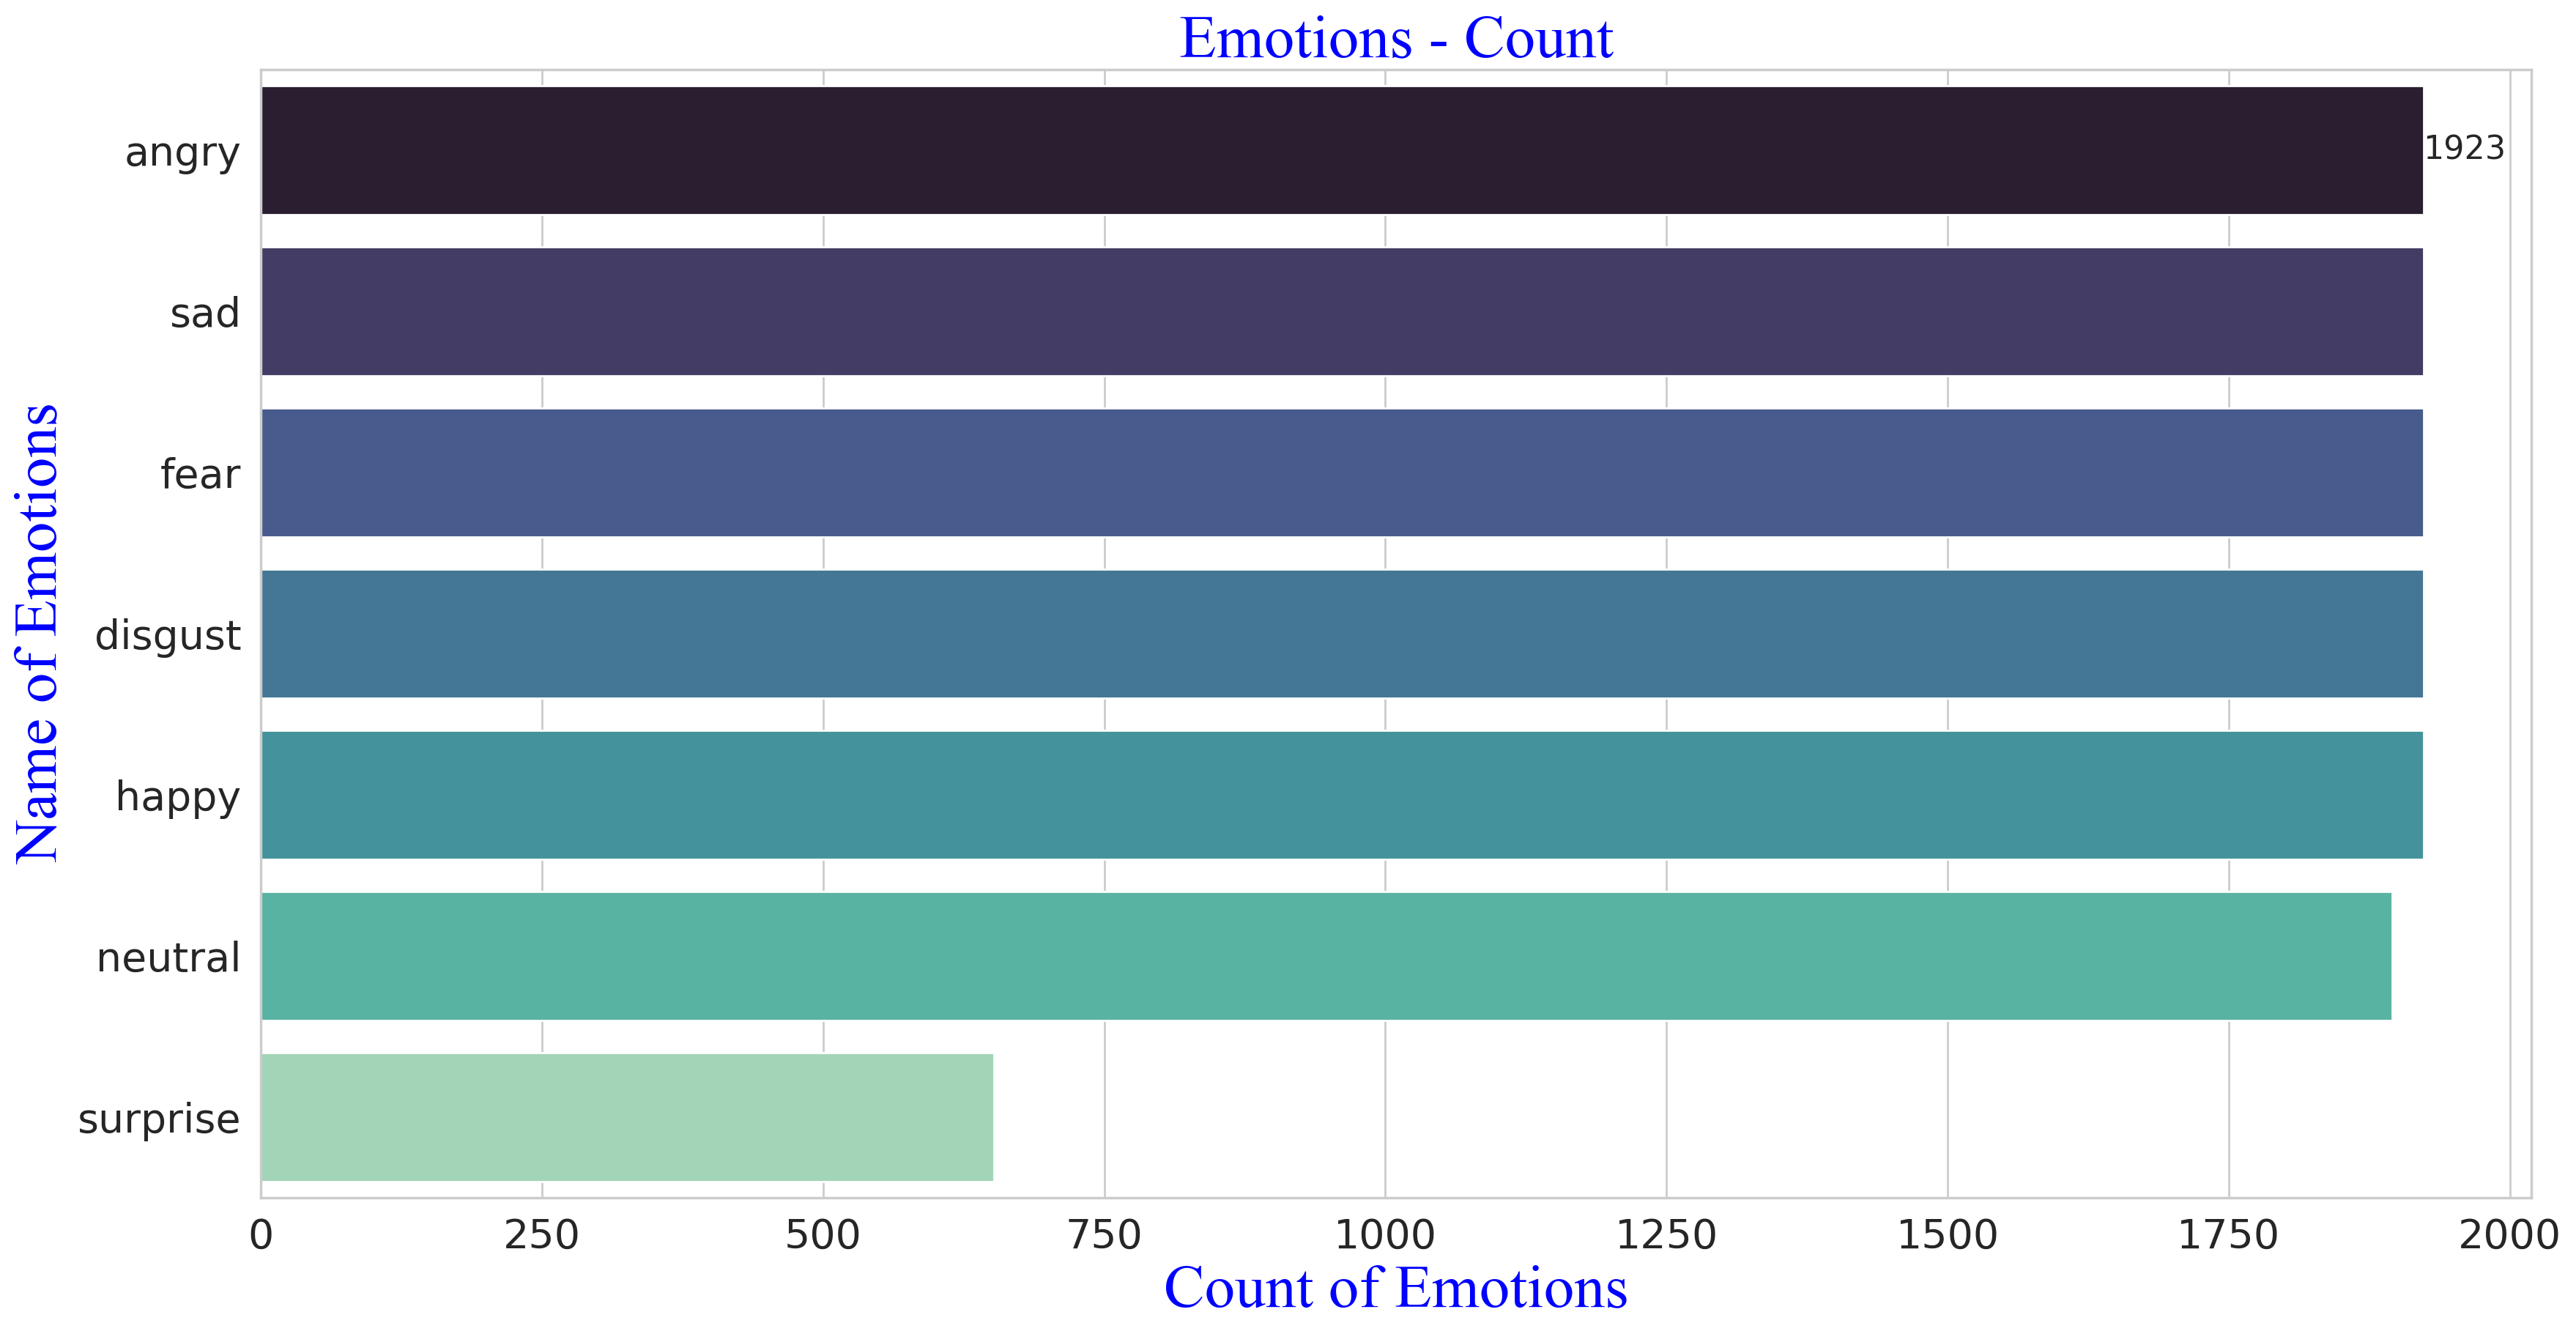

In [45]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [46]:
Sum_df_rep = Sum_df
Sum_df_rep['Emotions'].replace('happiness', 'happy', inplace=True)
Sum_df_rep['Emotions'].replace('sadness', 'sad', inplace=True)
Sum_df_rep['Emotions'].replace('calm', 'neutral', inplace=True)

In [47]:
[Sum_df_rep["Emotions"].unique().tolist() for i in Sum_df_rep.columns]

[['angry', 'sad', 'fear', 'disgust', 'happy', 'neutral', 'surprise'],
 ['angry', 'sad', 'fear', 'disgust', 'happy', 'neutral', 'surprise']]

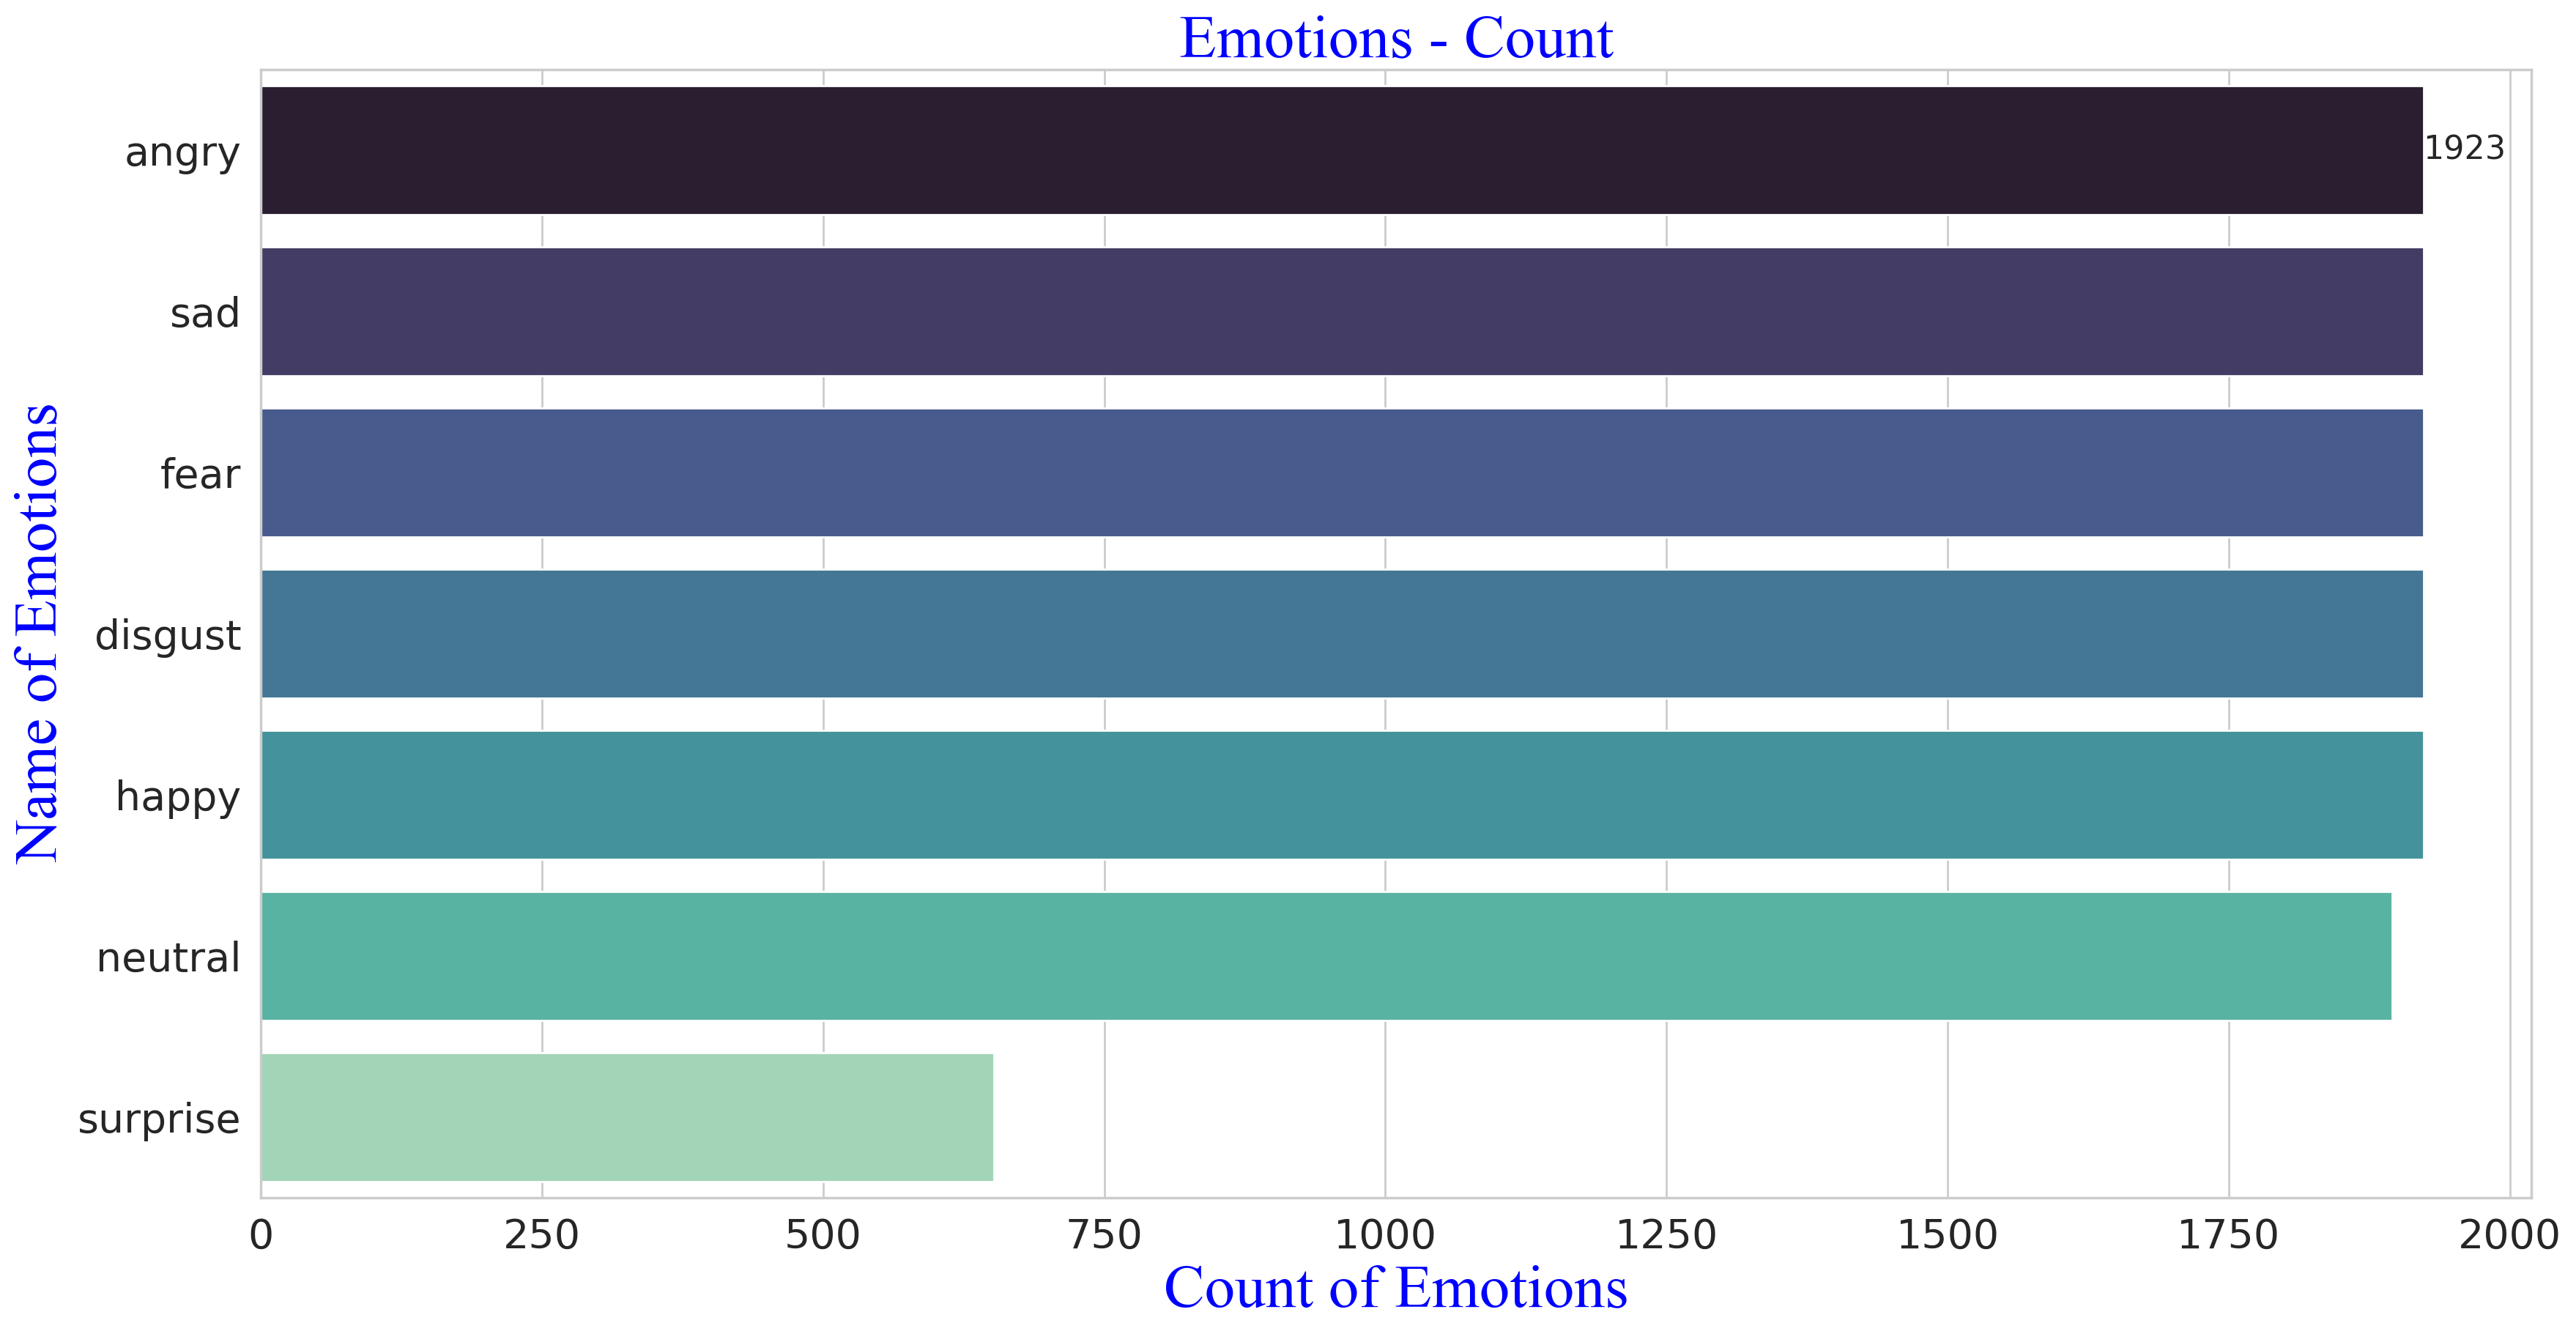

In [48]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df_rep['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [52]:
%%time
audio_arrays = []

for i in Sum_df_rep['Path']:
    # Check if the file exists before loading it
    if os.path.exists(i):
        y, sr = librosa.load(i, sr=44100)
        audio_arrays.append(y)
    else:
        print(f"File not found: {i}")  # Print a message for missing files
        audio_arrays.append(None)      # Append None to maintain list length

Sum_df_rep['Arrays'] = audio_arrays

File not found: /content/SaveeDC_d03.wav
File not found: /content/SaveeJK_a02.wav
File not found: /content/SaveeJE_f10.wav
File not found: /content/SaveeKL_a02.wav
File not found: /content/SaveeJK_h15.wav
File not found: /content/SaveeDC_a06.wav
File not found: /content/SaveeDC_h08.wav
File not found: /content/SaveeKL_n28.wav
File not found: /content/SaveeKL_a03.wav
File not found: /content/SaveeKL_d09.wav
File not found: /content/SaveeJK_su08.wav
File not found: /content/SaveeJE_n19.wav
File not found: /content/SaveeJE_n04.wav
File not found: /content/SaveeKL_sa04.wav
File not found: /content/SaveeKL_d14.wav
File not found: /content/SaveeJK_f02.wav
File not found: /content/SaveeDC_su02.wav
File not found: /content/SaveeJK_sa01.wav
File not found: /content/SaveeJE_n20.wav
File not found: /content/SaveeJK_n29.wav
File not found: /content/SaveeJE_a14.wav
File not found: /content/SaveeKL_a04.wav
File not found: /content/SaveeDC_n11.wav
File not found: /content/SaveeJE_n29.wav
File not fou

In [53]:
Sum_df_rep.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

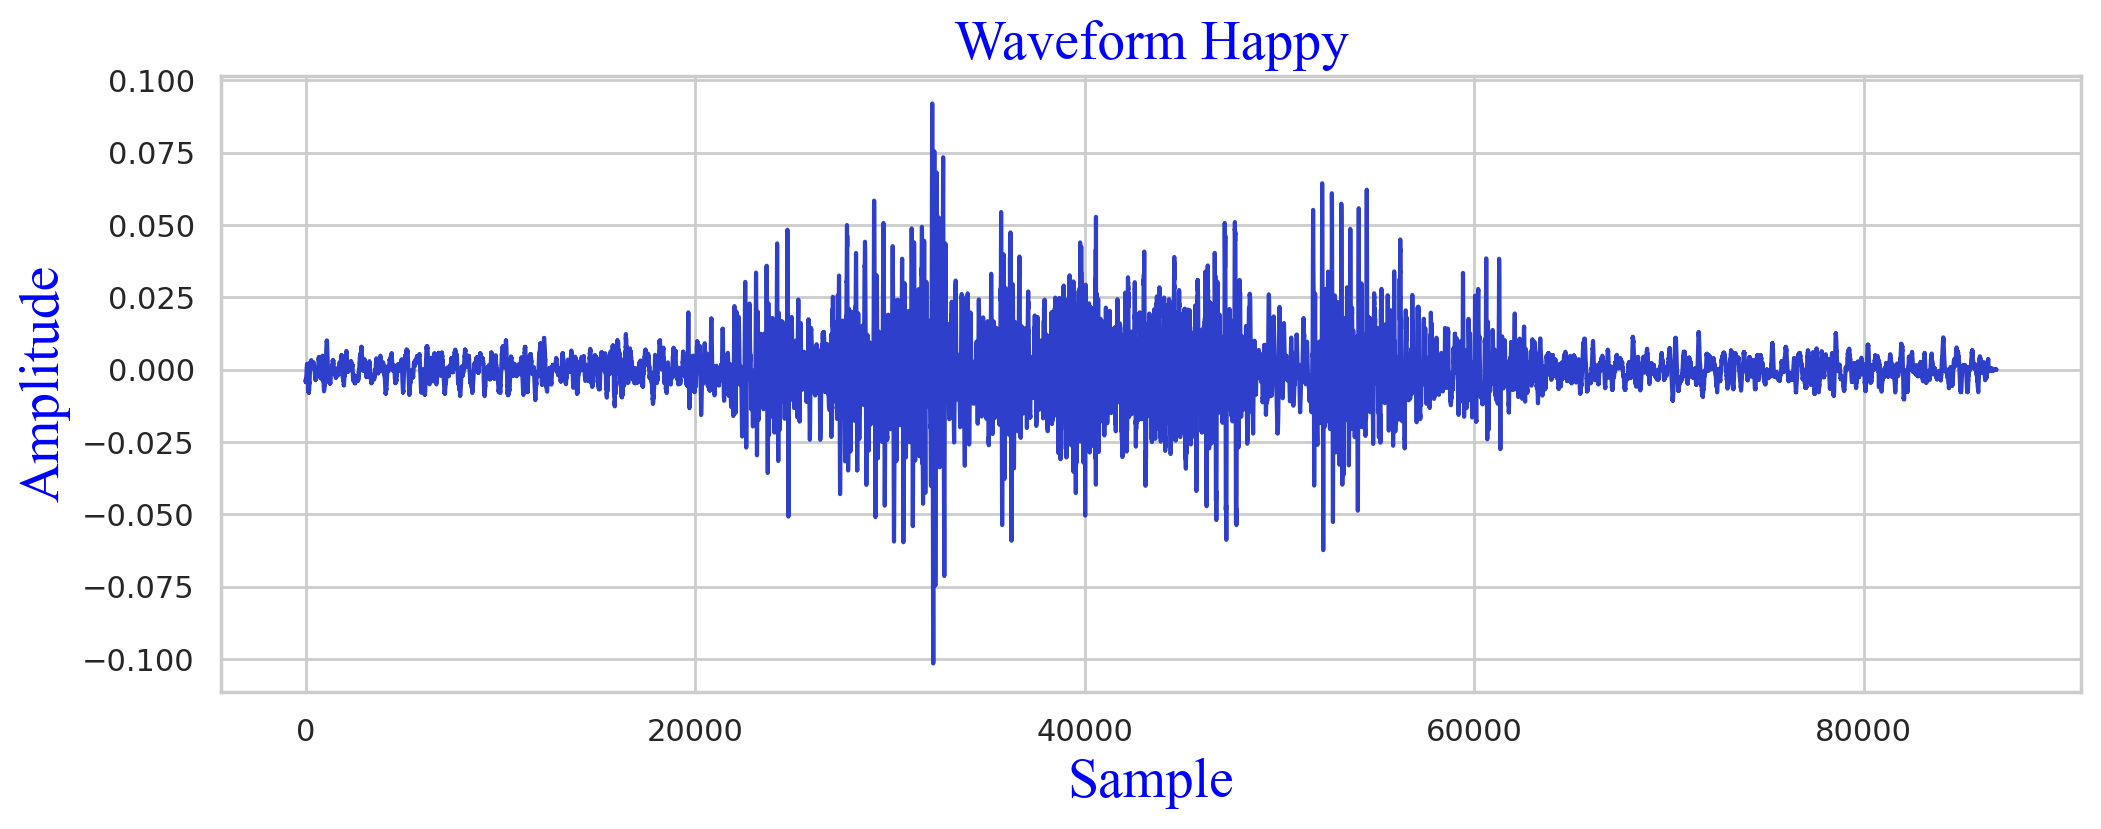

In [54]:
happy_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'happy']['Path']
happy_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'happy']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Happy', fontdict= font2)
plt.show()

Audio(happy_sp.iloc[0])

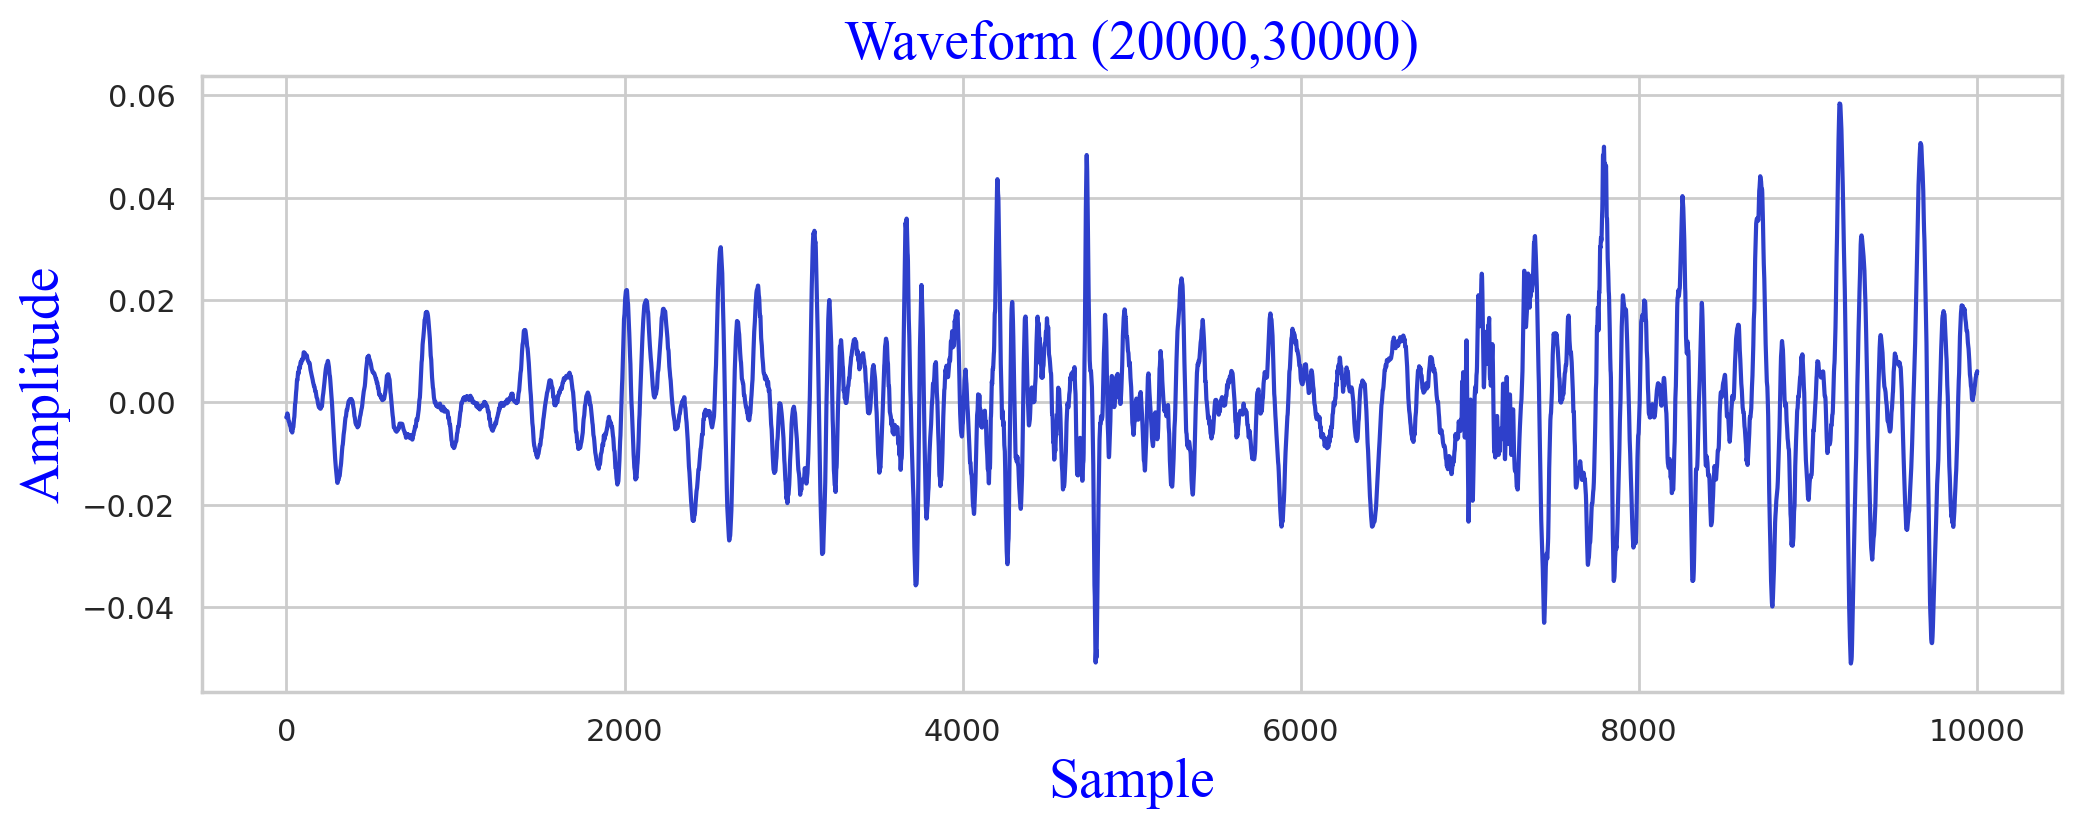

In [55]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:30000], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (20000,30000)', fontdict= font2)
plt.show()

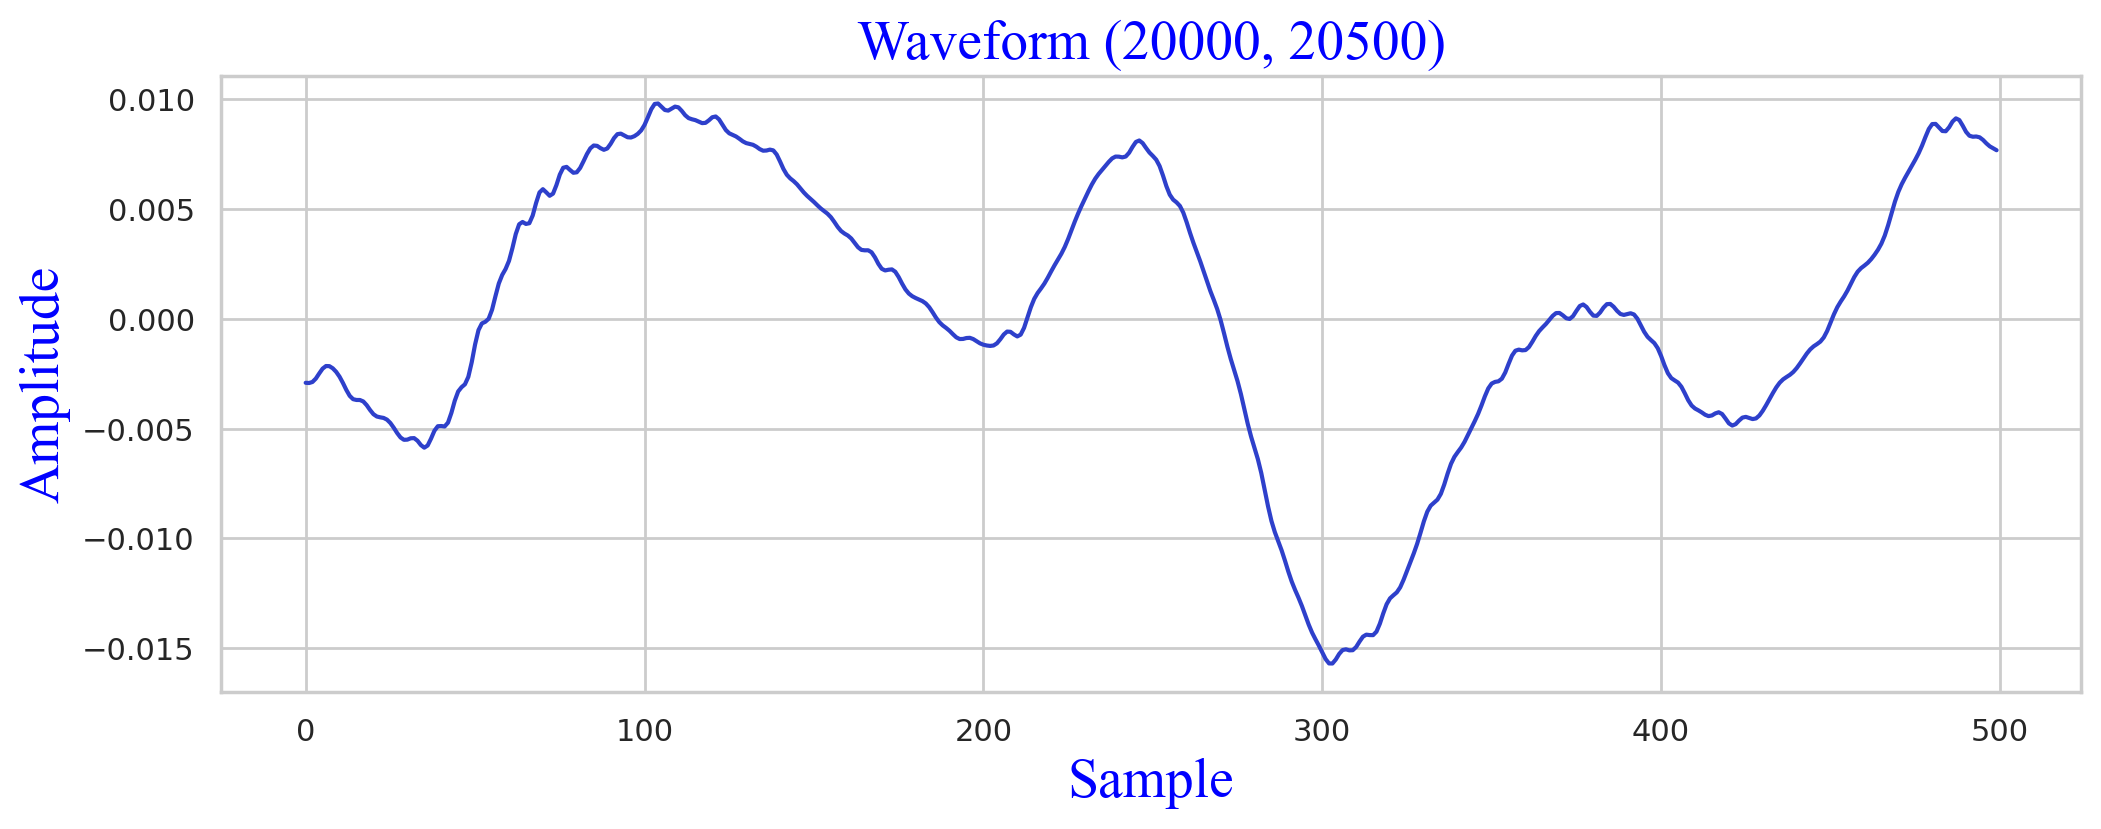

In [56]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:20500], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (20000, 20500)', fontdict= font2)
plt.show()

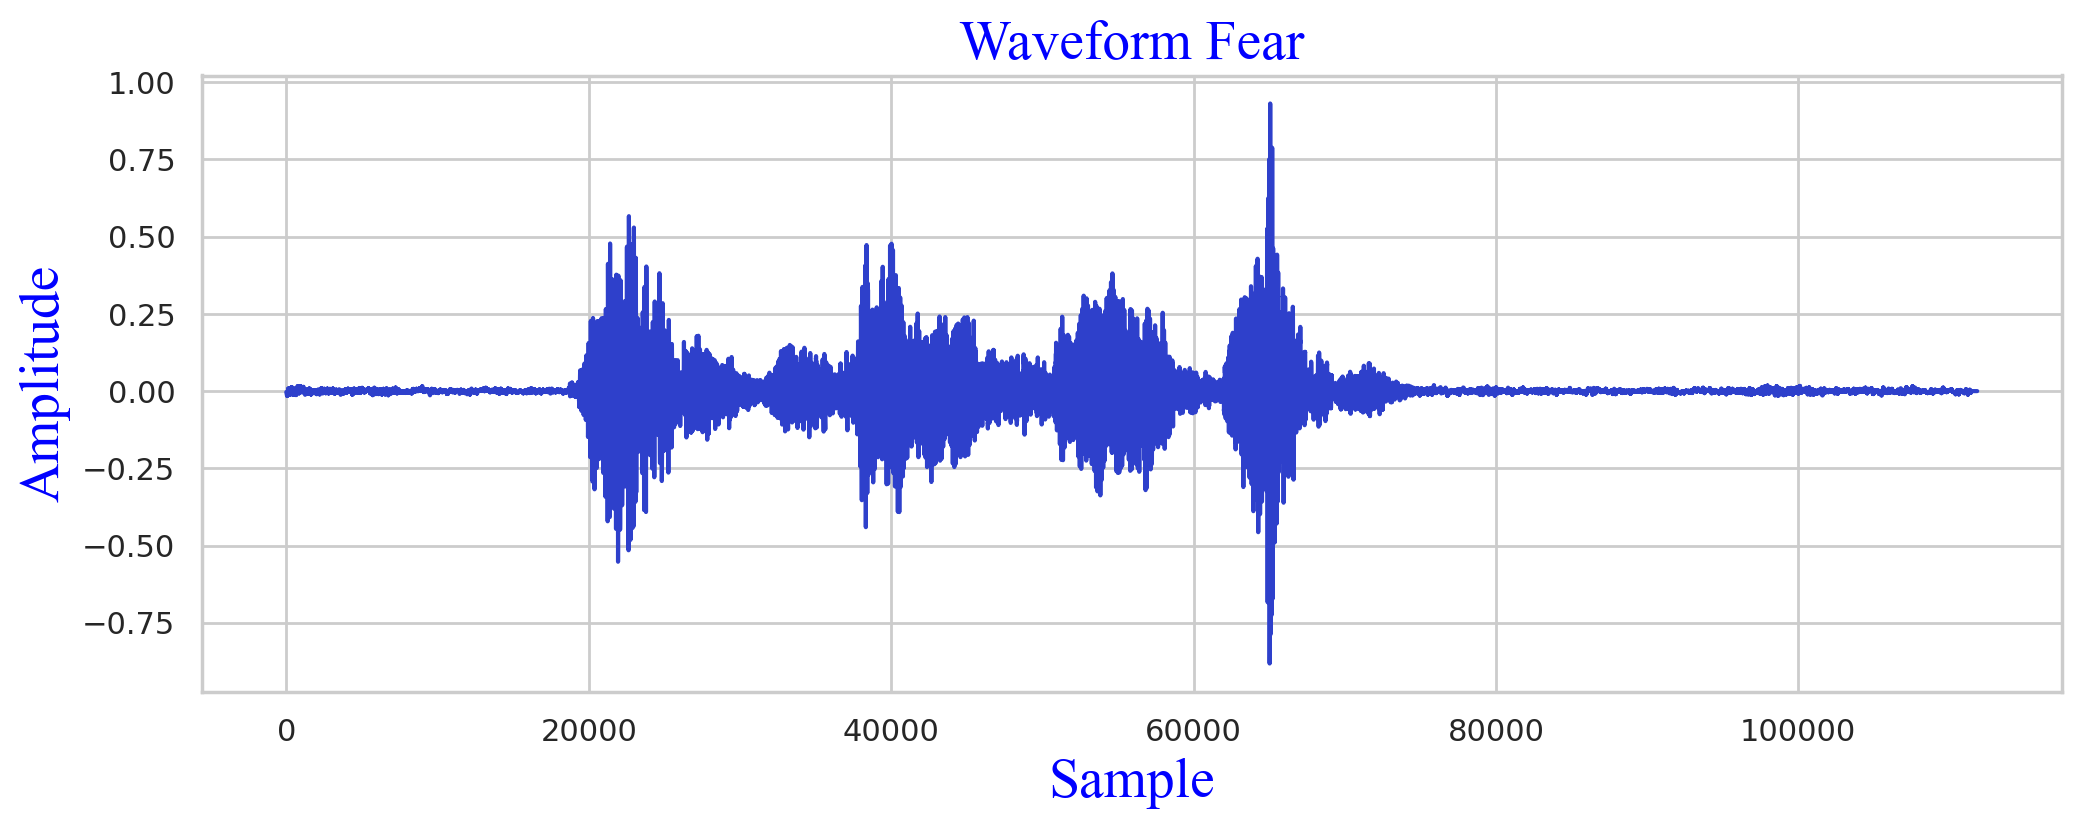

In [57]:
fear_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'fear']['Path']
fear_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'fear']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(fear_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Fear', fontdict= font2)
plt.show()

Audio(fear_sp.iloc[0])

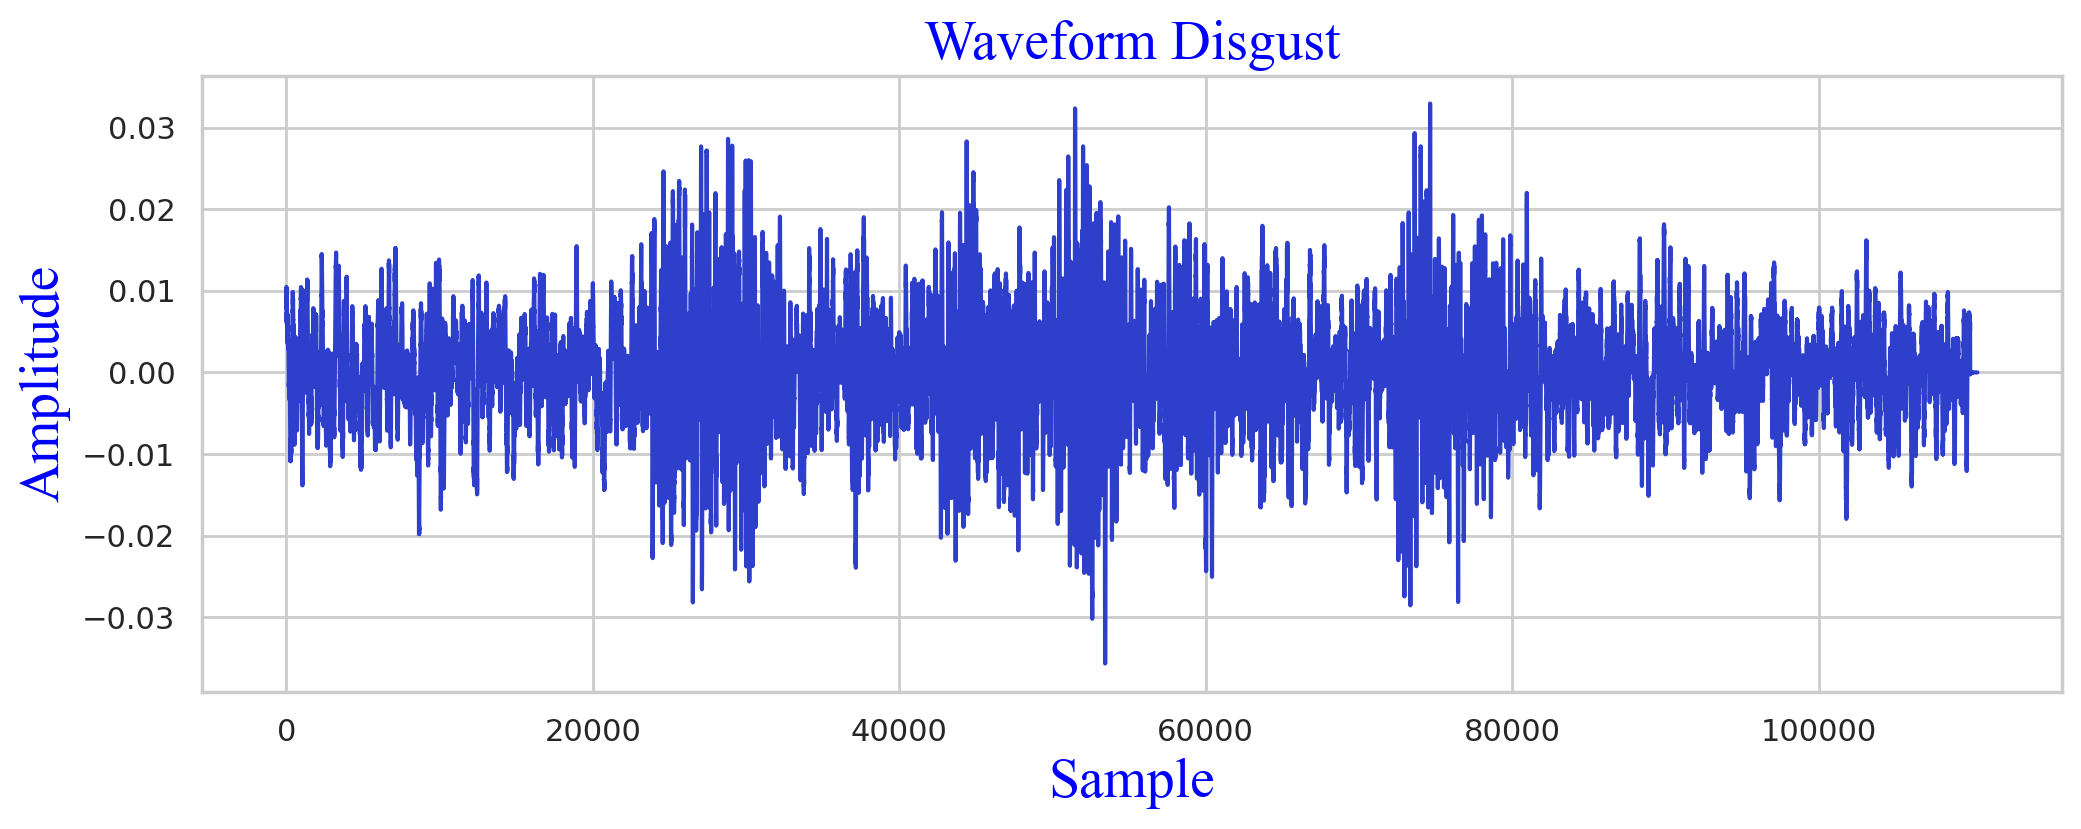

In [58]:
disgust_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'disgust']['Path']
disgust_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'disgust']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(disgust_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Disgust', fontdict= font2)
plt.show()

Audio(disgust_sp.iloc[0])

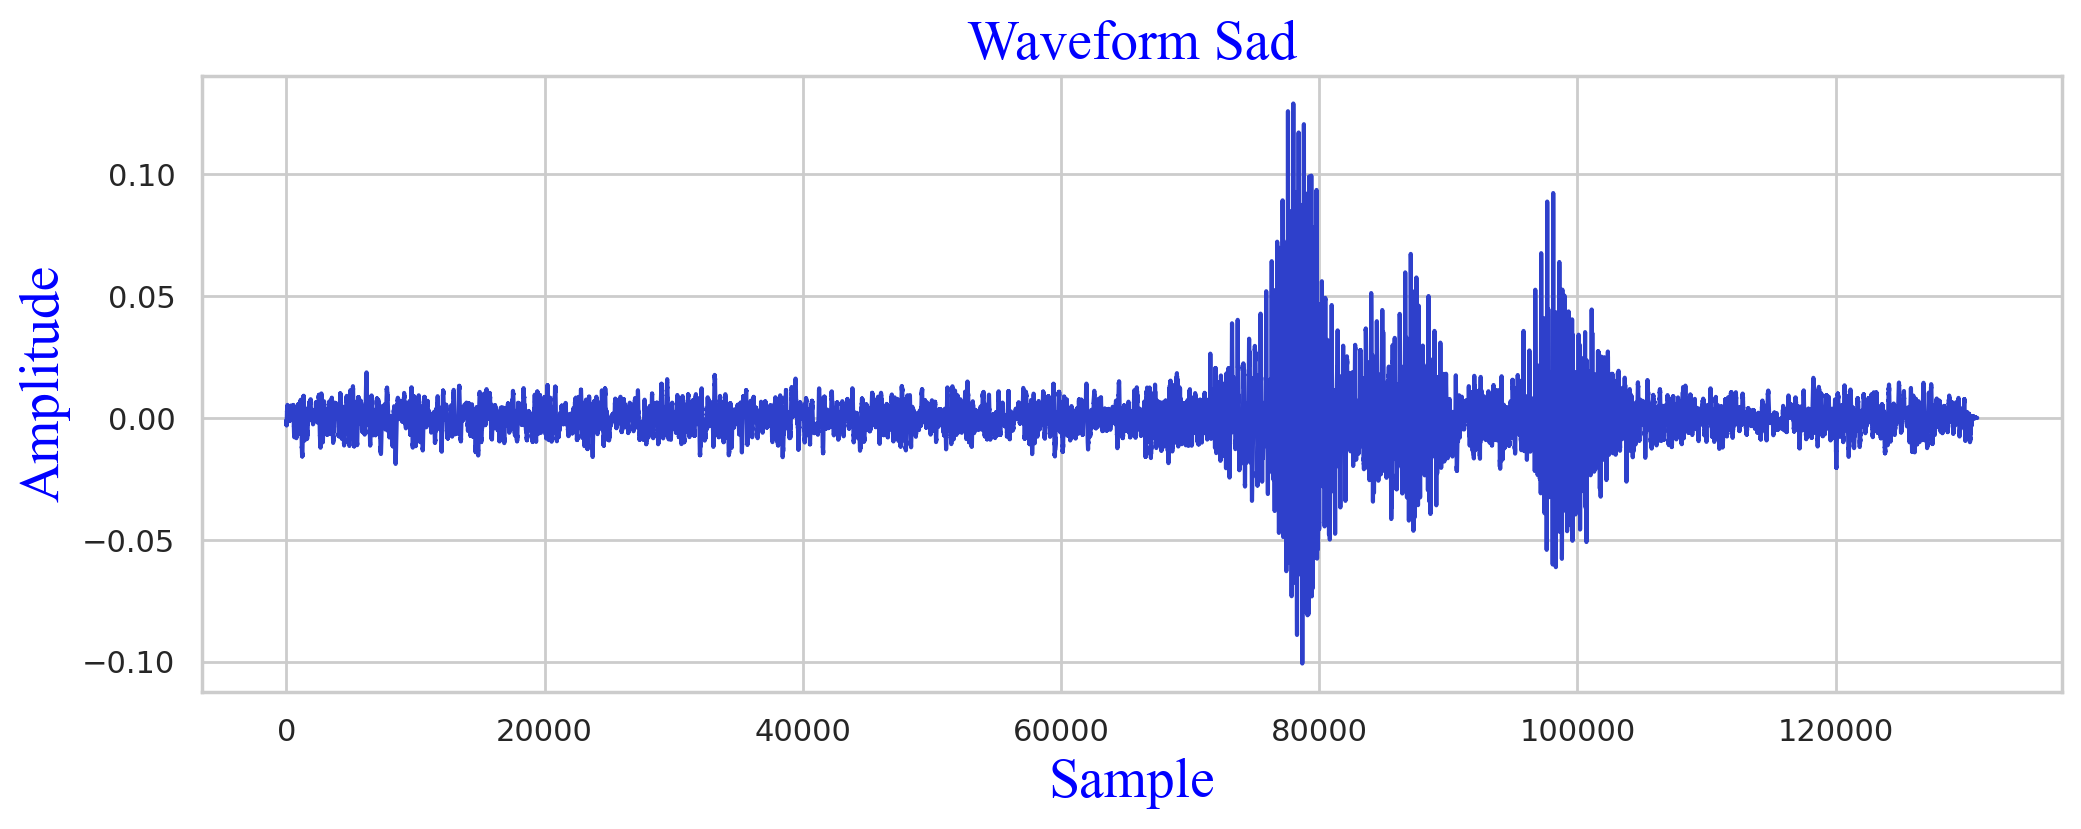

In [59]:
sad_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'sad']['Path']
sad_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'sad']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(sad_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Sad', fontdict= font2)
plt.show()

Audio(sad_sp.iloc[0])

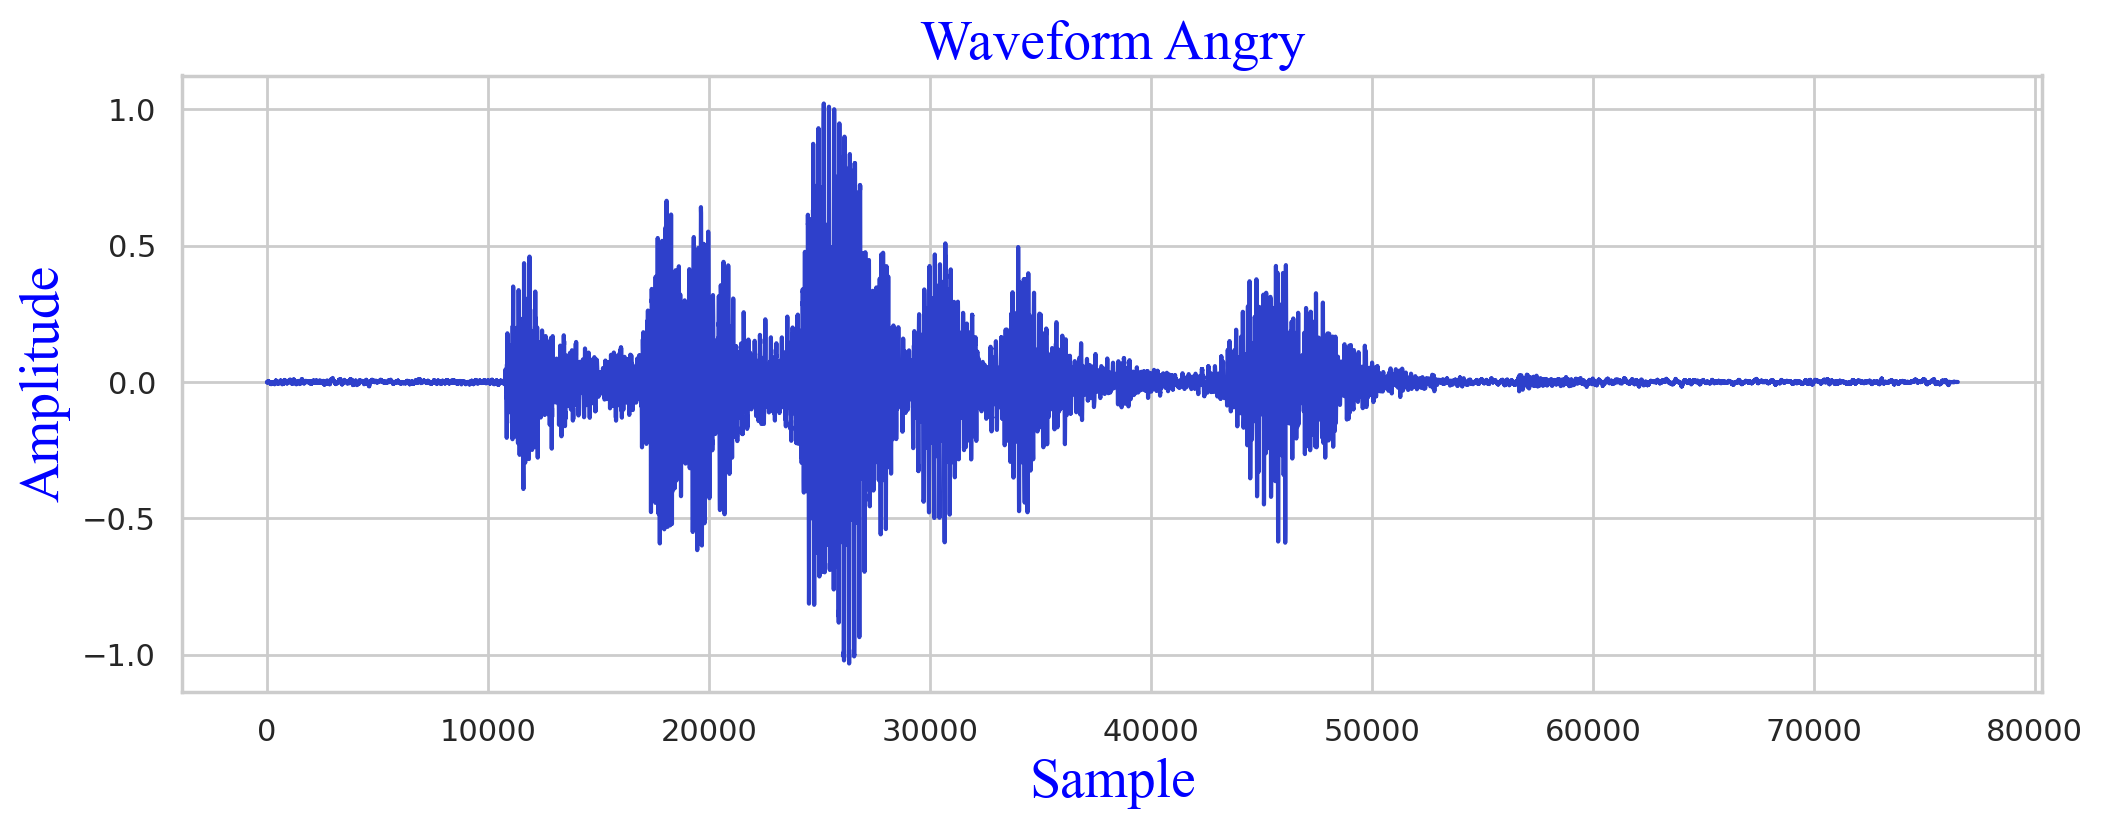

In [60]:
angry_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'angry']['Path']
angry_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'angry']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(angry_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Angry', fontdict= font2)
plt.show()

Audio(angry_sp.iloc[0])

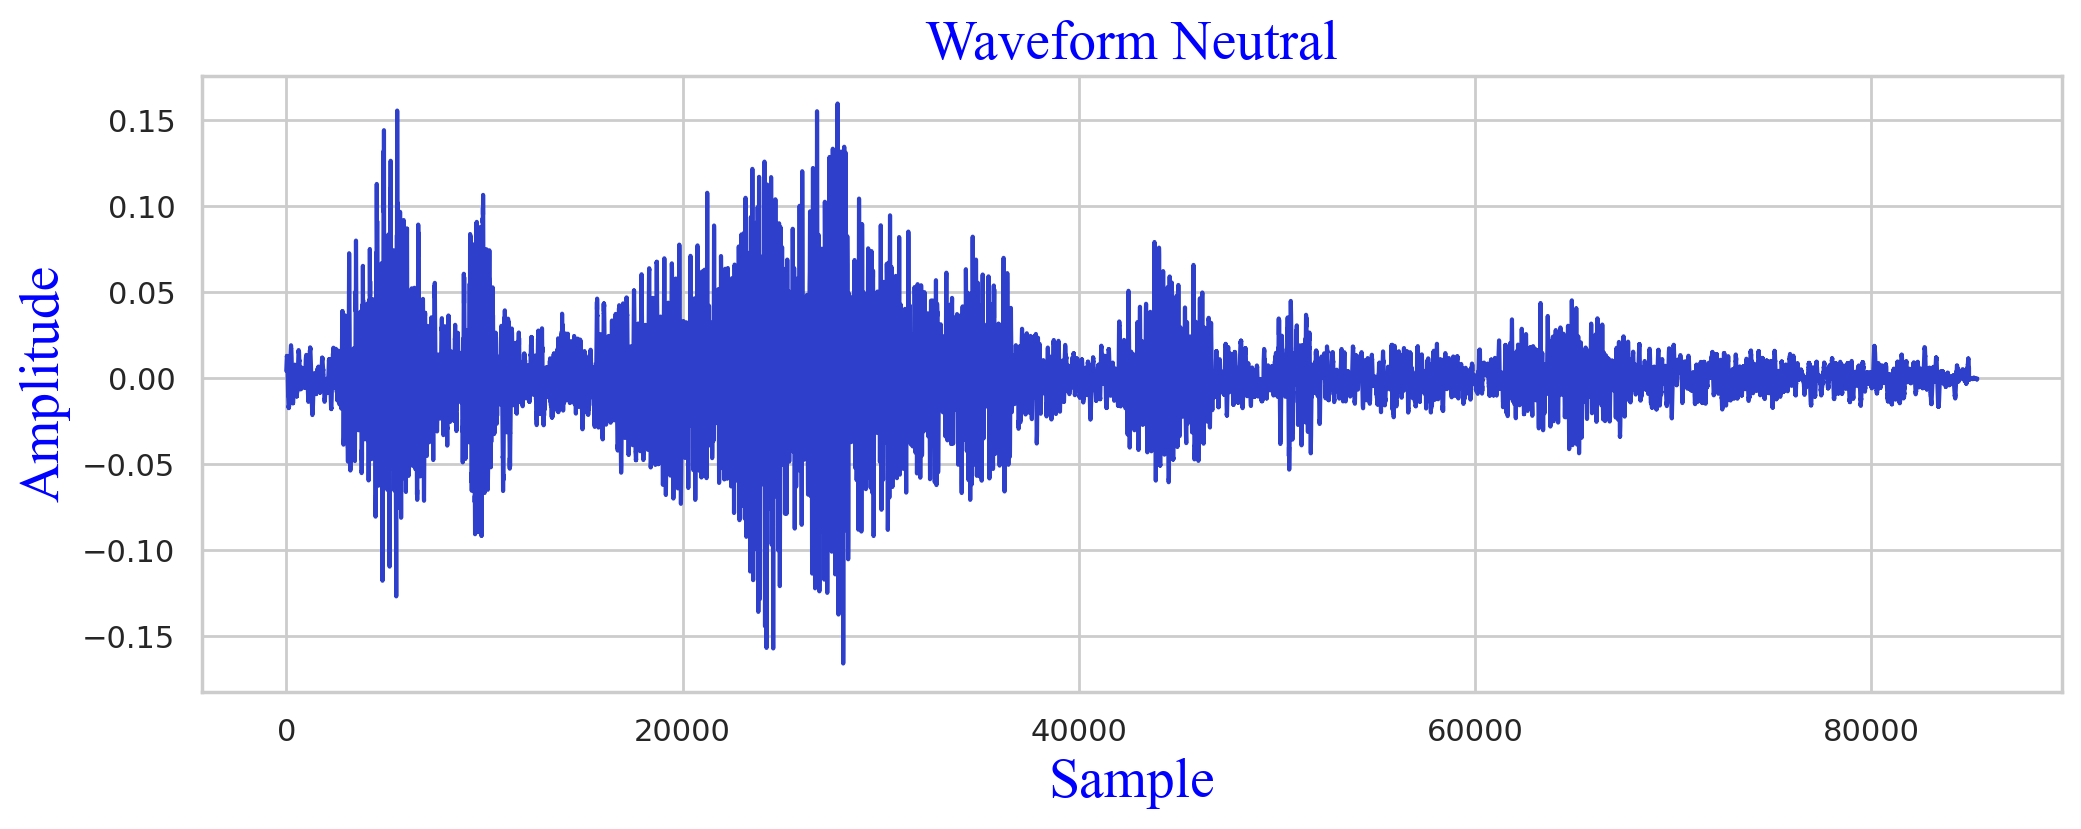

In [61]:
neutral_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'neutral']['Path']
neutral_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'neutral']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(neutral_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Neutral', fontdict= font2)
plt.show()

Audio(neutral_sp.iloc[0])

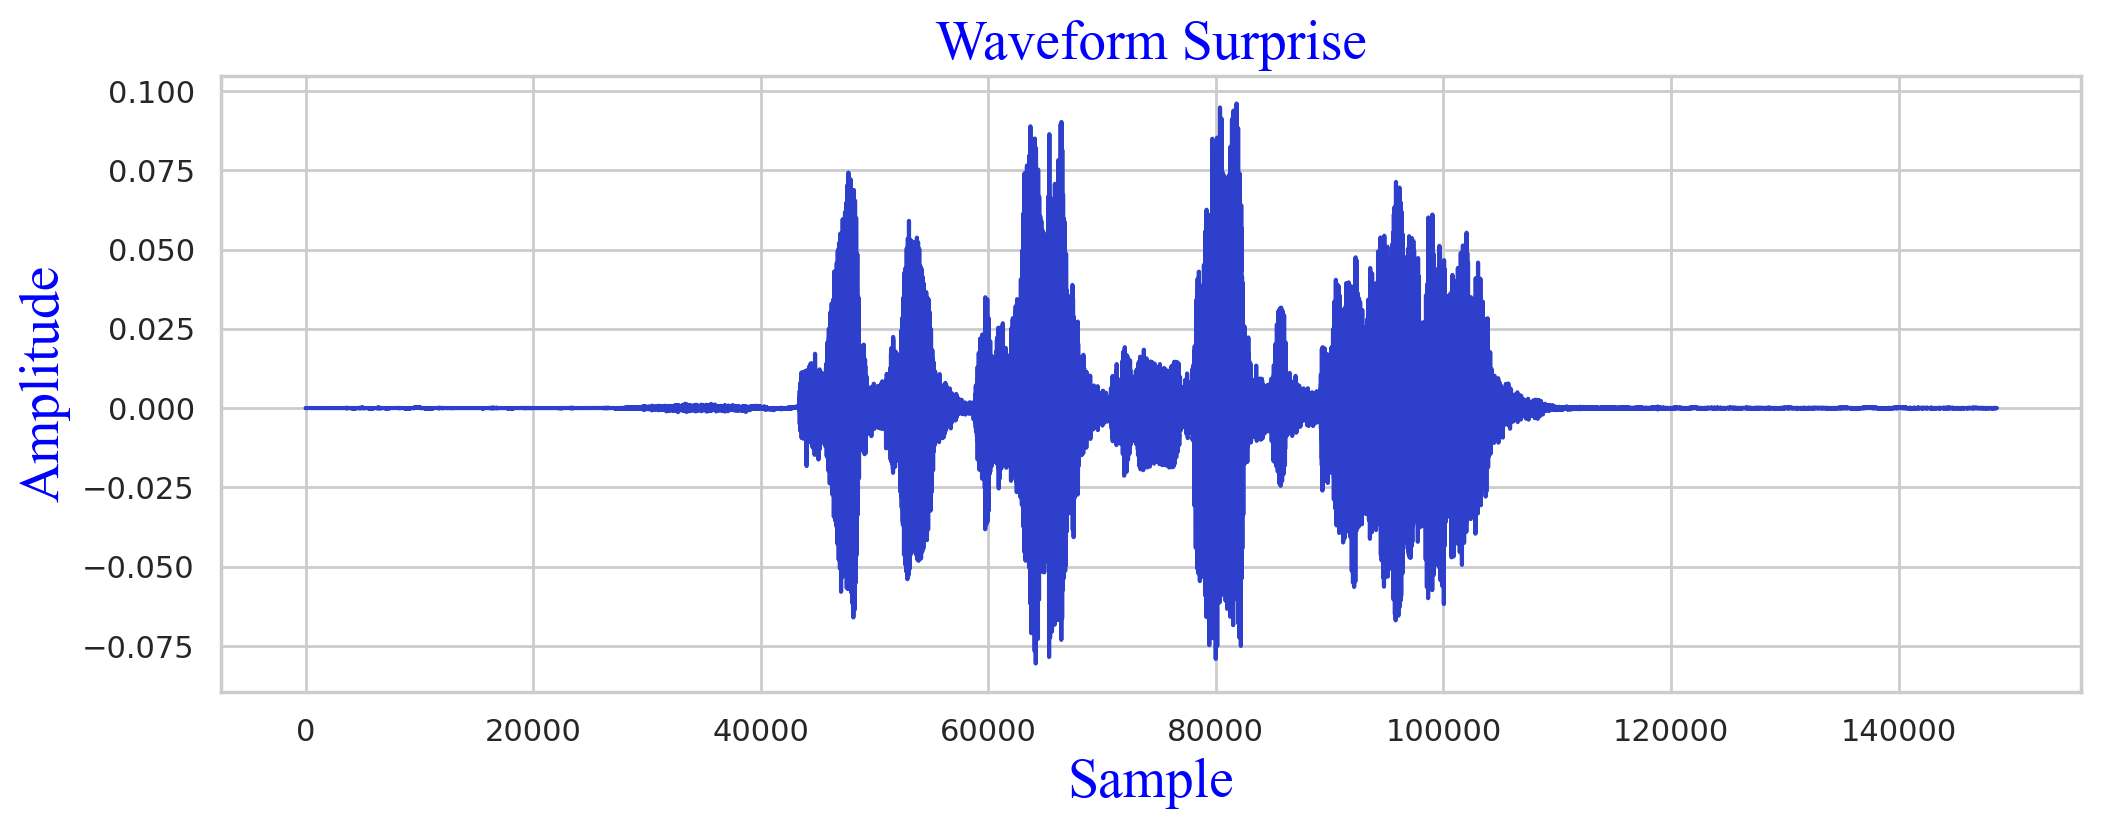

In [62]:
surprise_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'surprise']['Path']
surprise_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'surprise']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(surprise_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform Surprise', fontdict= font2)
plt.show()

Audio(surprise_sp.iloc[0])

In [63]:
sample_duration = 1/sr
print(sample_duration)

2.2675736961451248e-05


In [64]:
#duration of the audio signals in seconds
duration = sample_duration * len(audio_arrays)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 0.28 seconds


In [65]:
Frame_size = 1024
#HOP =  Current frame how many samples shift to the right for calculating the next frame
Hop_lenght = 512

#calculate the amplitude envelope

def amplitude_env (signal, frame_size, hop_length):
    amplitude_envelope = []

    #calculate AE (Amp Env) for each frame
    for i in range (0, len(signal), hop_length):
        current_frame_amplitude_env = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_env)

    return np.array(amplitude_envelope)


def fancy_amplitude_env (signal, frame_size, hop_length):

    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

In [66]:
# Samples

Sp_fear = fear_arr.iloc[0]
Sp_disgust= disgust_arr.iloc[0]
Sp_happy= happy_arr.iloc[0]
Sp_sad = sad_arr.iloc[0]
Sp_neutral = neutral_arr.iloc[0]
Sp_angry = angry_arr.iloc[0]
Sp_surprise = surprise_arr.iloc[0]

In [67]:
AE_fear = amplitude_env(Sp_fear, Frame_size, Hop_lenght)
AE_disgust = amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
AE_happy = amplitude_env(Sp_happy, Frame_size, Hop_lenght)
AE_sad = amplitude_env(Sp_sad, Frame_size, Hop_lenght)
AE_neutral = amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
AE_angry = amplitude_env(Sp_angry, Frame_size, Hop_lenght)
AE_surprise = amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(AE_fear), len(AE_disgust), len(AE_angry), len(AE_happy), len(AE_neutral),
     len(AE_surprise), len(AE_sad))

219 216 150 170 167 291 256


In [68]:
fancy_AE_fear = fancy_amplitude_env(Sp_fear, Frame_size, Hop_lenght)
fancy_AE_disgust = fancy_amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
fancy_AE_happy = fancy_amplitude_env(Sp_happy, Frame_size, Hop_lenght)
fancy_AE_sad = fancy_amplitude_env(Sp_sad, Frame_size, Hop_lenght)
fancy_AE_neutral = fancy_amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
fancy_AE_angry = fancy_amplitude_env(Sp_angry, Frame_size, Hop_lenght)
fancy_AE_surprise = fancy_amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(fancy_AE_fear), len(fancy_AE_disgust), len(fancy_AE_angry),
      len(fancy_AE_happy), len(fancy_AE_neutral),
     len(fancy_AE_surprise), len(fancy_AE_sad))

219 216 150 170 167 291 256


In [69]:
(AE_fear == fancy_AE_fear).all()

np.True_

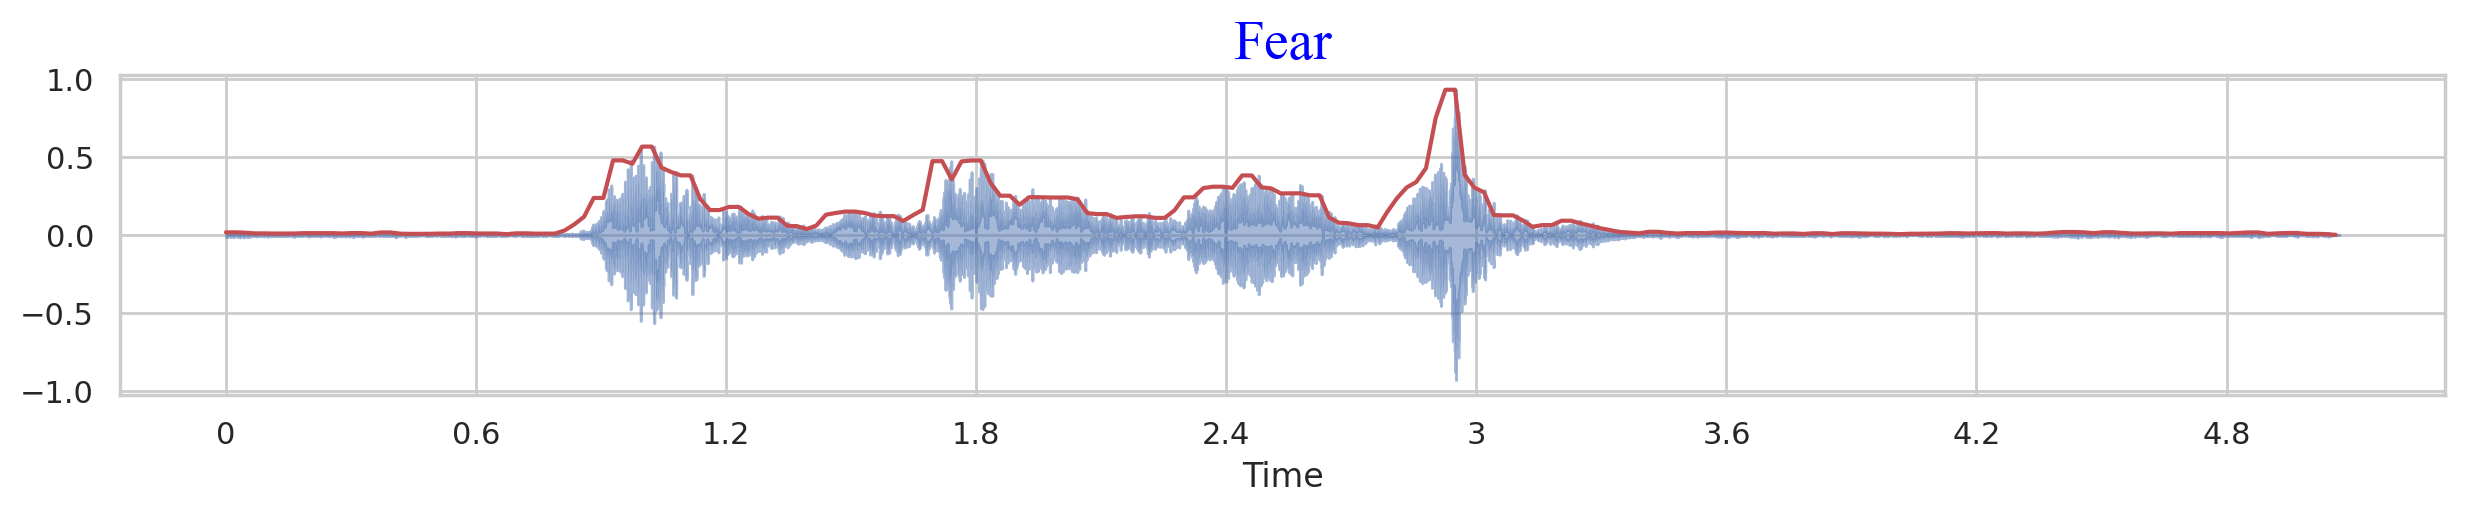

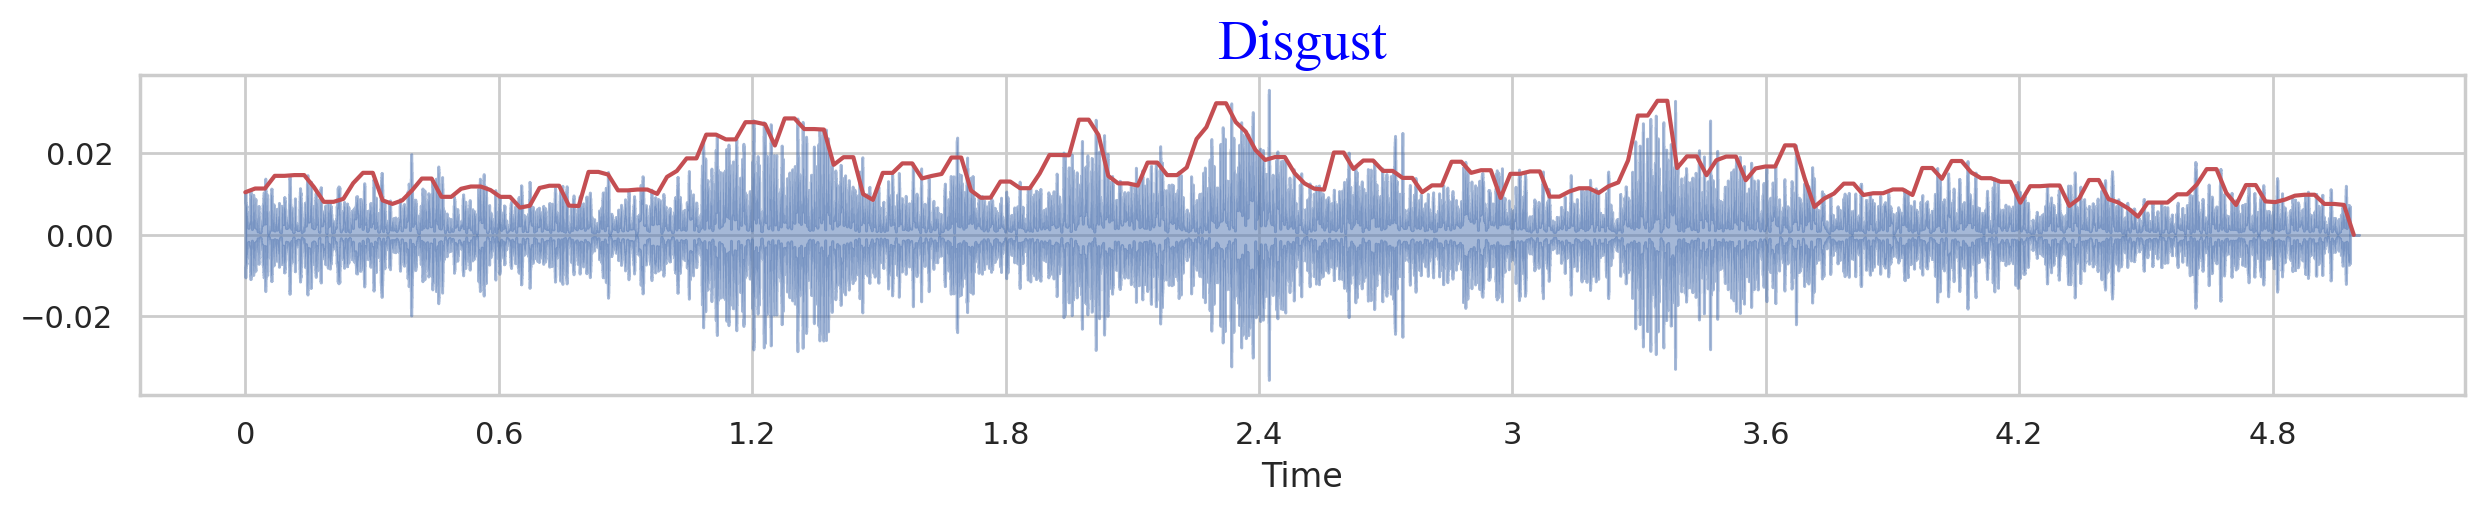

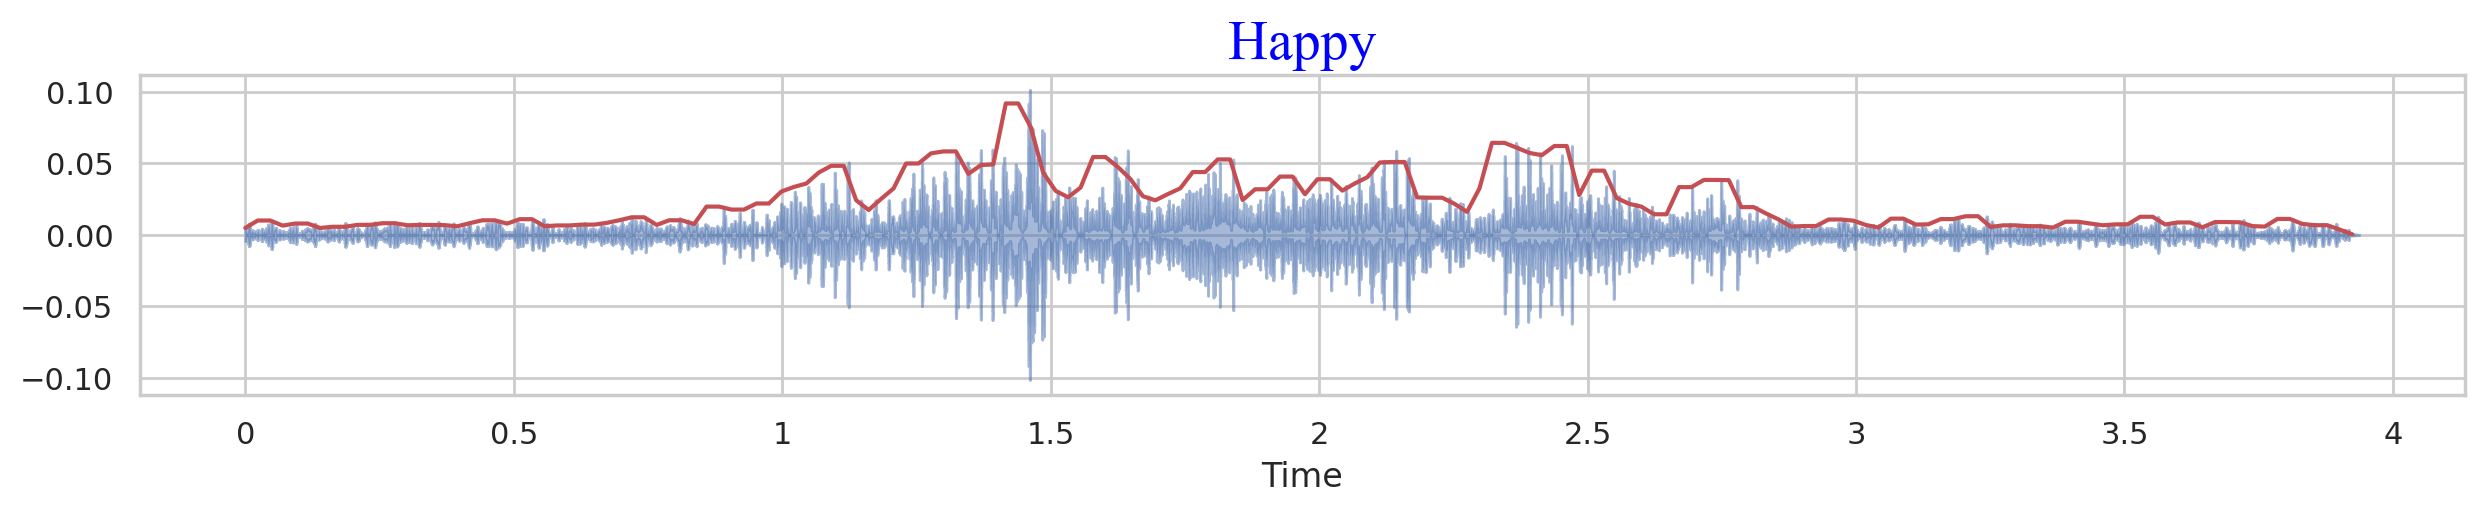

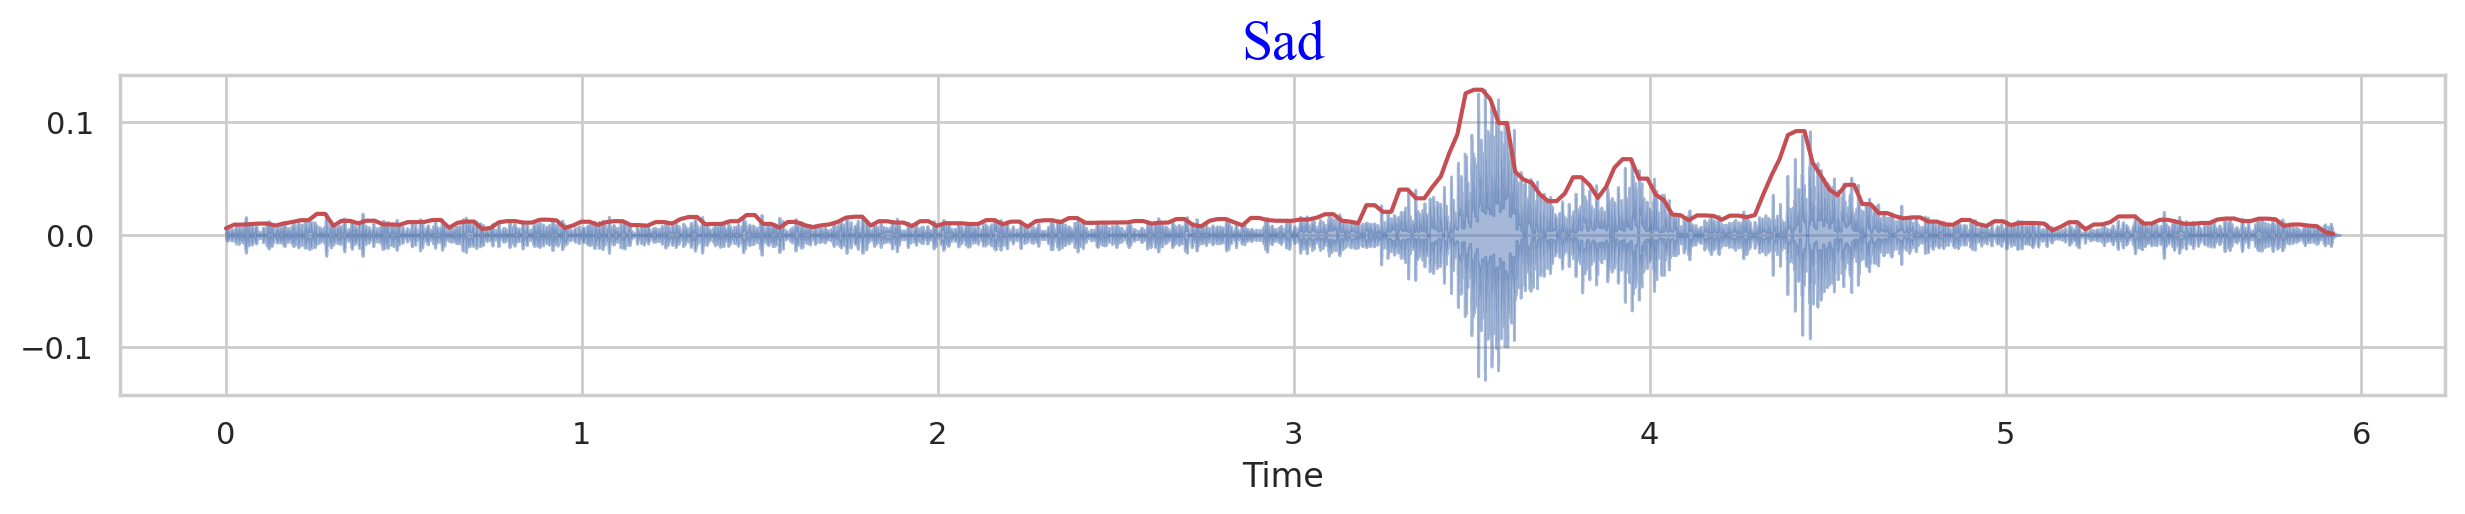

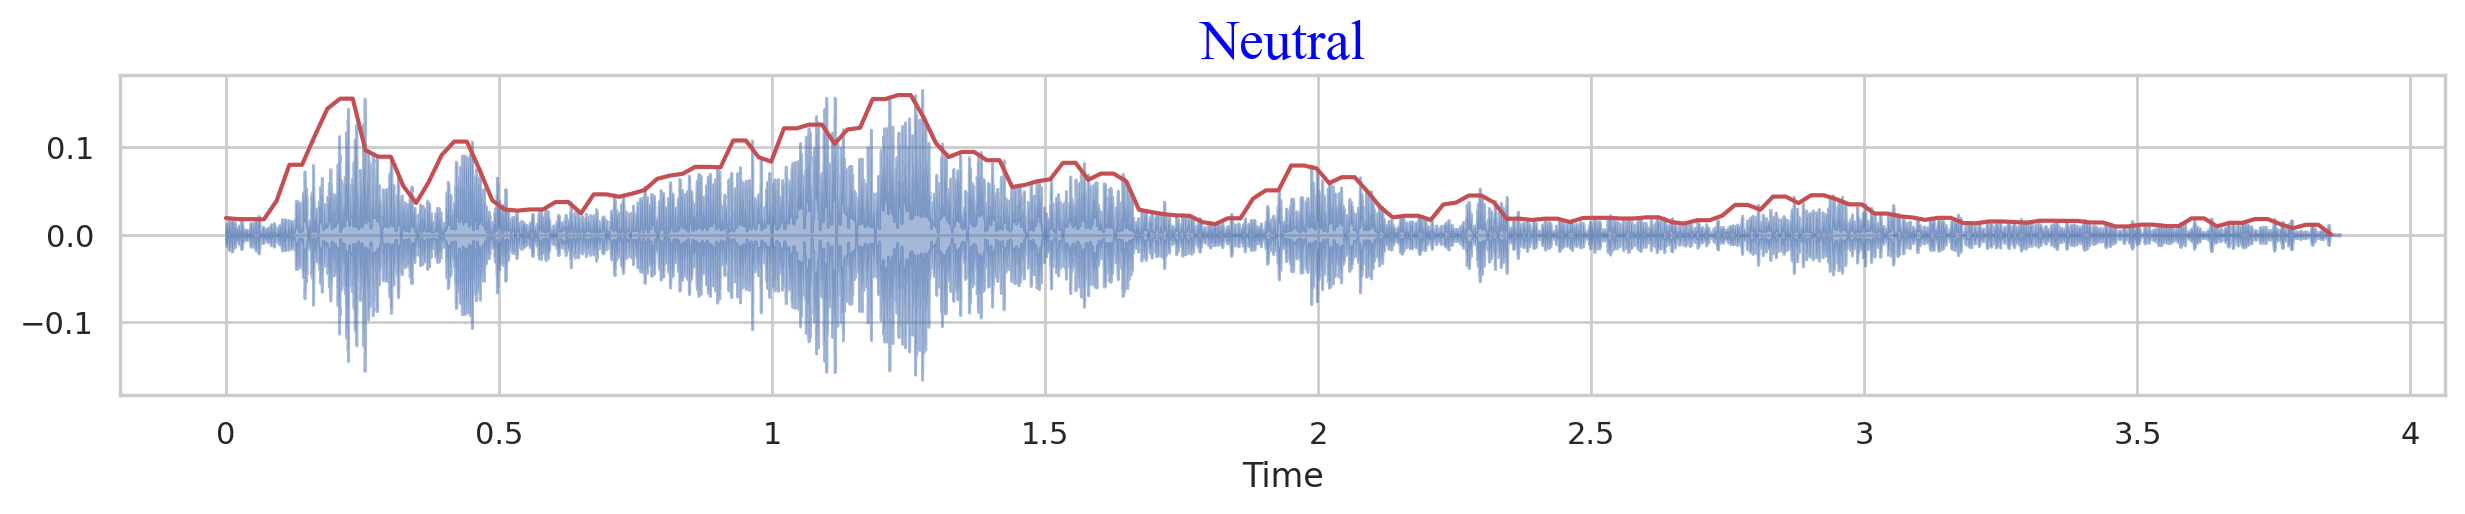

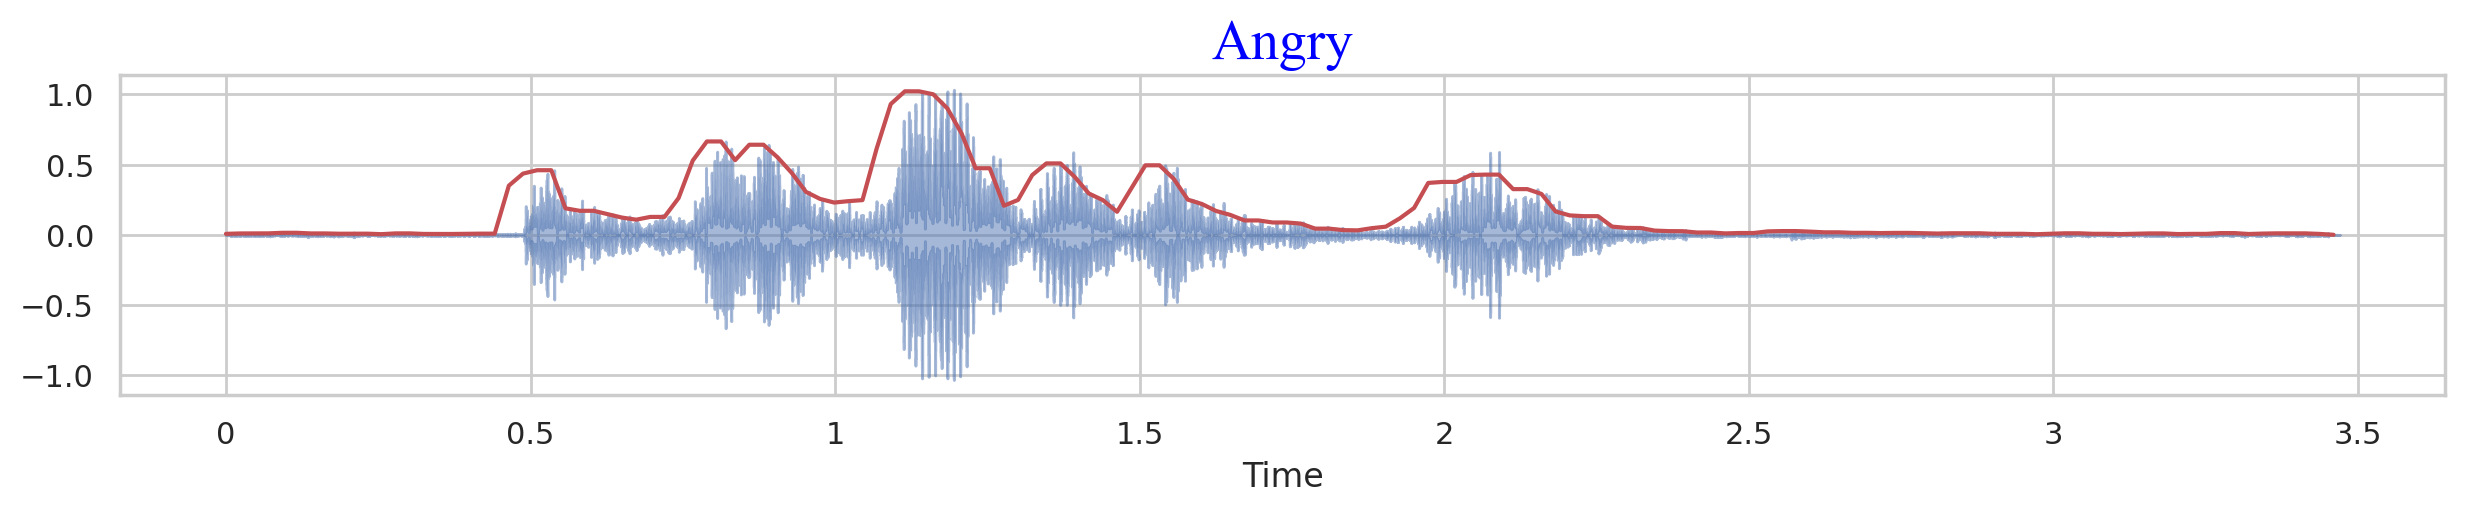

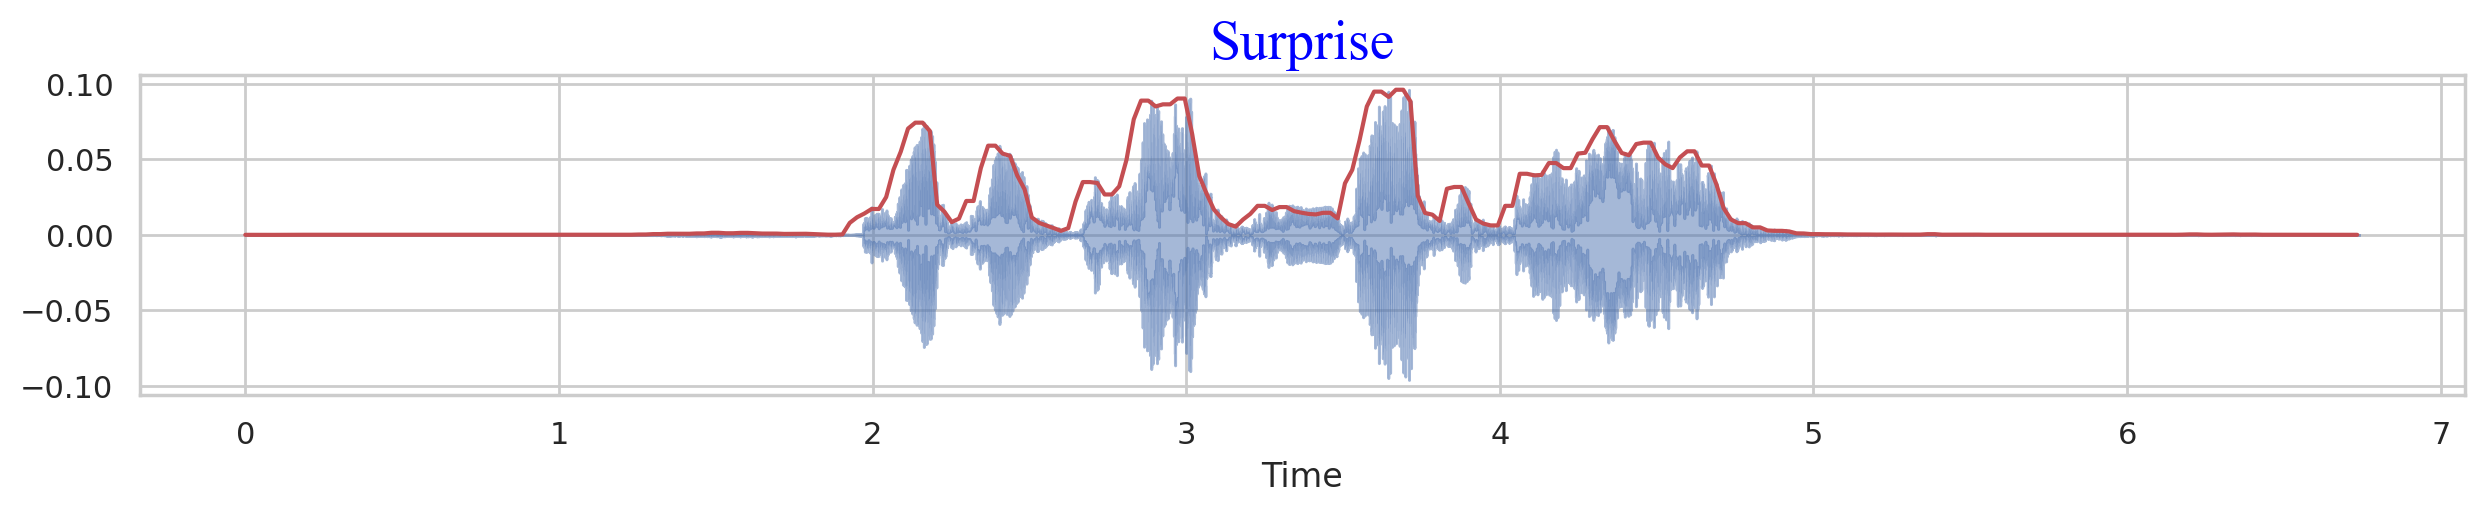

In [70]:
#Visualize amplitude envelope for all the audio files (Samples of each)

frames_fear = range(0, AE_fear.size)
frames_disgust = range(0, AE_disgust.size)
frames_happy = range(0, AE_happy.size)
frames_sad = range(0, AE_sad.size)
frames_neutral = range(0, AE_neutral.size)
frames_angry = range(0, AE_angry.size)
frames_surprise = range(0, AE_surprise.size)

t1 = librosa.frames_to_time(frames_fear, hop_length = Hop_lenght)
t2 = librosa.frames_to_time(frames_disgust, hop_length = Hop_lenght)
t3 = librosa.frames_to_time(frames_happy, hop_length = Hop_lenght)
t4 = librosa.frames_to_time(frames_sad, hop_length = Hop_lenght)
t5 = librosa.frames_to_time(frames_neutral, hop_length = Hop_lenght)
t6 = librosa.frames_to_time(frames_angry, hop_length = Hop_lenght)
t7 = librosa.frames_to_time(frames_surprise, hop_length = Hop_lenght)


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,1)
librosa.display.waveshow(Sp_fear, alpha = 0.5)
plt.plot(t1, AE_fear, color = "r")
plt.title("Fear", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,2)
librosa.display.waveshow(Sp_disgust, alpha = 0.5)
plt.plot(t2, AE_disgust, color = "r")
plt.title("Disgust", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,3)
librosa.display.waveshow(Sp_happy, alpha = 0.5)
plt.plot(t3, AE_happy, color = "r")
plt.title("Happy", fontdict= font2)
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,4)
librosa.display.waveshow(Sp_sad, alpha = 0.5)
plt.plot(t4, AE_sad, color = "r")
plt.title("Sad", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,5)
librosa.display.waveshow(Sp_neutral, alpha = 0.5)
plt.plot(t5, AE_neutral, color = "r")
plt.title("Neutral", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,6)
librosa.display.waveshow(Sp_angry, alpha = 0.5)
plt.plot(t6, AE_angry, color = "r")
plt.title("Angry", fontdict= font2)
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,7)
librosa.display.waveshow(Sp_surprise, alpha = 0.5)
plt.plot(t7, AE_surprise, color = "r")
plt.title("Surprise", fontdict= font2)
plt.show()

In [71]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data



def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)


# taking any example and checking for techniques.
path = np.array(Sum_df_rep.Path)[1]
data, sample_rate = librosa.load(path)

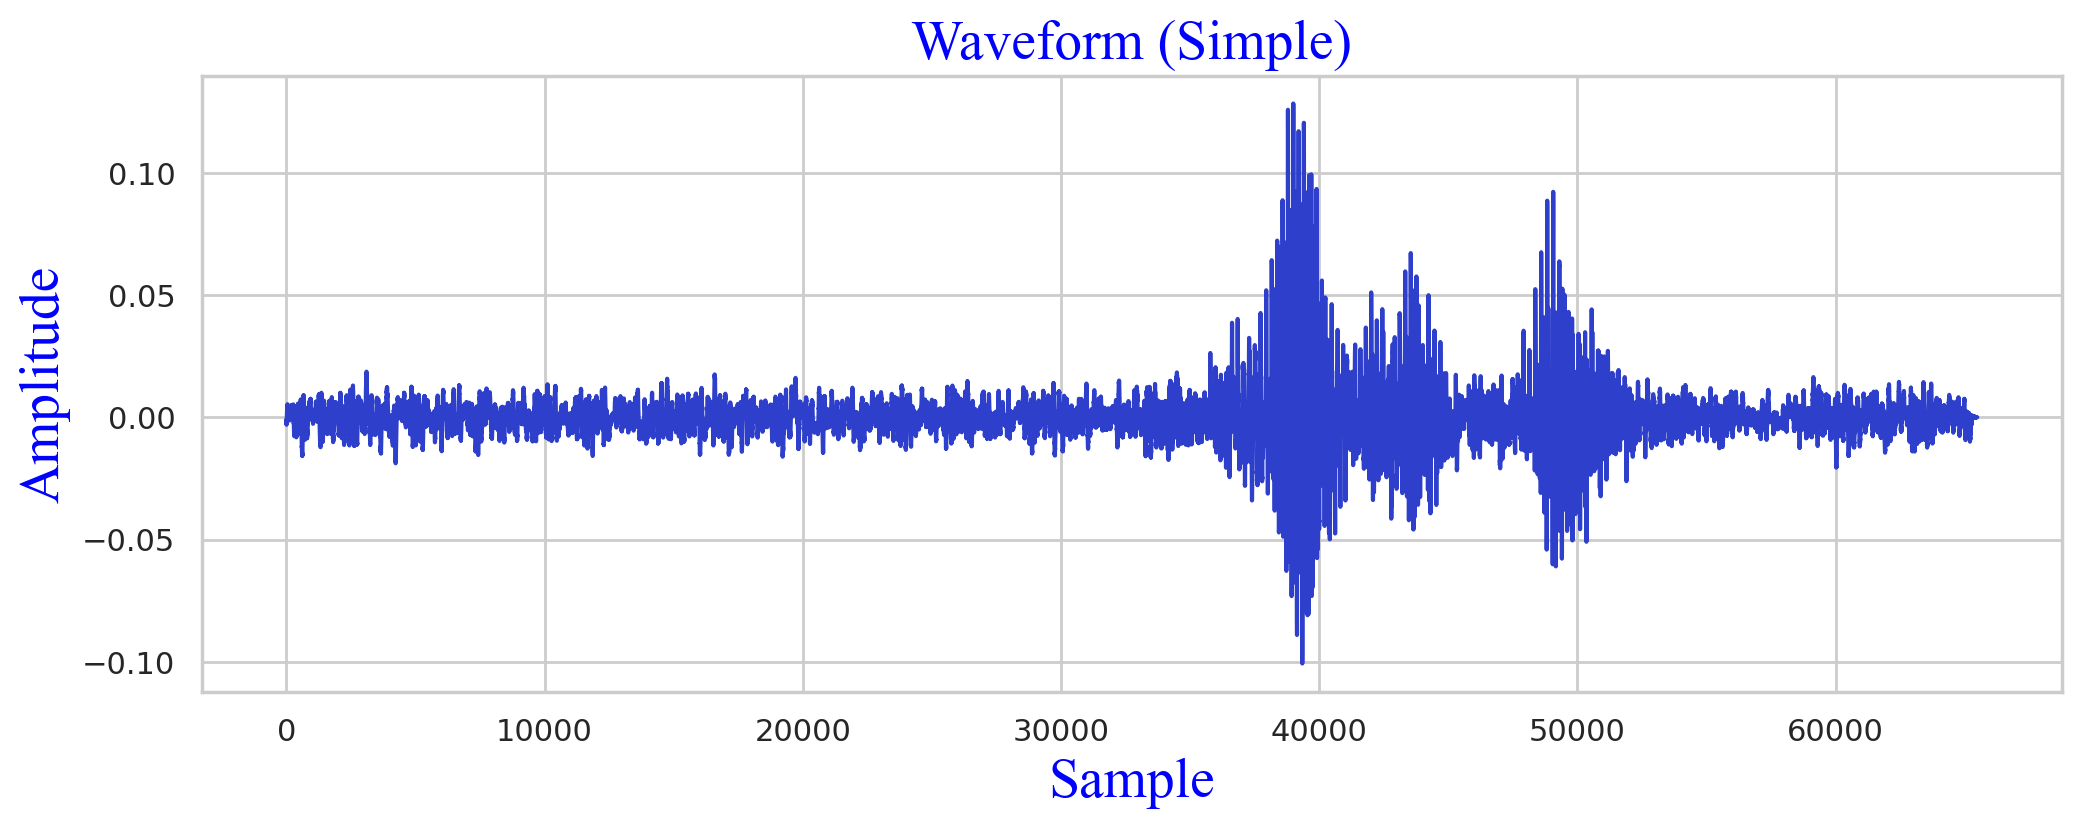

In [72]:
Simple_data = data
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Simple_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Simple)', fontdict= font2)
plt.show()

Audio(Simple_data, rate=sample_rate)

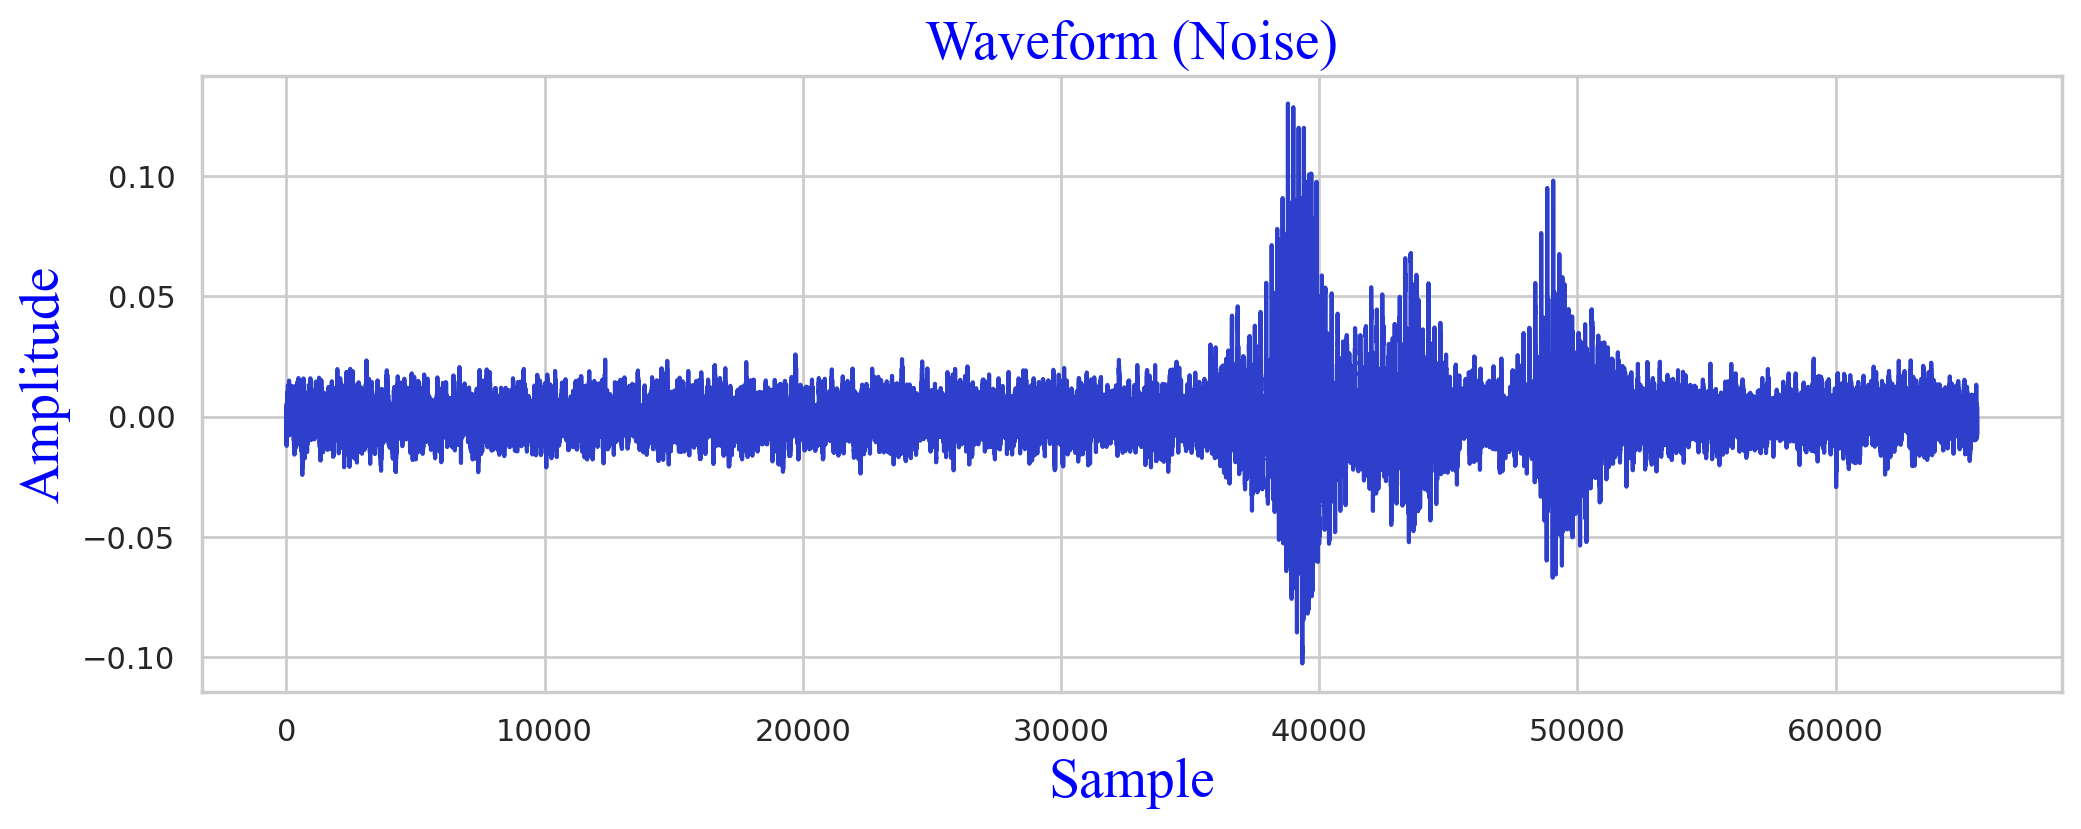

In [73]:
Noise_data = noise(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Noise_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Noise)', fontdict= font2)
plt.show()

Audio(Noise_data, rate=sample_rate)

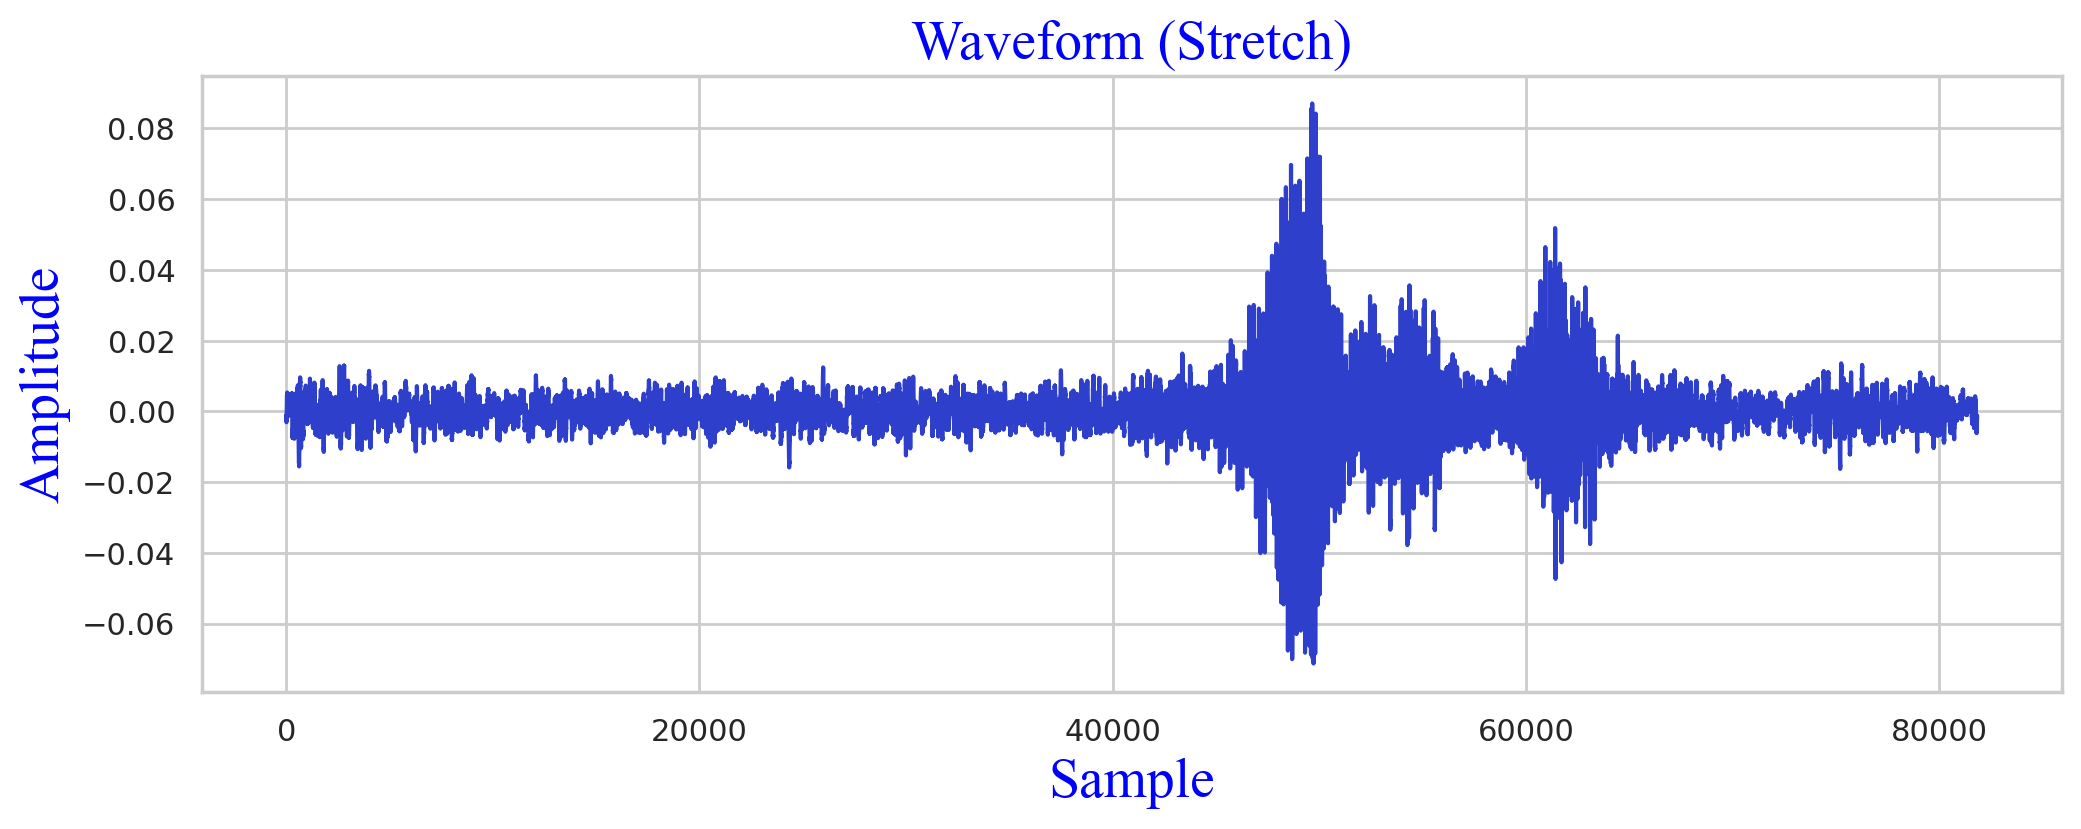

In [74]:
Stretch_data = stretch(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Stretch_data ,color='#2E40CB')
plt.xlabel('Sample', fontdict= font2)
plt.ylabel('Amplitude', fontdict= font2)
plt.title('Waveform (Stretch)', fontdict= font2)
plt.show()

Audio(Stretch_data, rate=sample_rate)

In [75]:
Crema_df

Emotions                                Path
0       angry  /content/Crema/1077_IEO_ANG_MD.wav
1         sad  /content/Crema/1080_IEO_SAD_LO.wav
2        fear  /content/Crema/1009_DFA_FEA_XX.wav
3     disgust  /content/Crema/1075_TAI_DIS_XX.wav
4        fear  /content/Crema/1070_DFA_FEA_XX.wav
...       ...                                 ...
7437    happy  /content/Crema/1056_ITS_HAP_XX.wav
7438  neutral  /content/Crema/1059_IOM_NEU_XX.wav
7439     fear  /content/Crema/1037_IWL_FEA_XX.wav
7440  disgust  /content/Crema/1020_ITH_DIS_XX.wav
7441      sad  /content/Crema/1007_IEO_SAD_MD.wav

[7442 rows x 2 columns]

In [76]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [77]:
extract_mfcc(Crema_df['Path'][0])

array([-2.84307465e+02,  1.20467636e+02,  6.95460320e+00,  1.98492813e+01,
       -2.05748882e+01,  3.26915026e+00, -5.80798388e+00, -2.83534837e+00,
       -1.17964592e+01,  1.28306258e+00,  2.77988601e+00,  1.34890723e+00,
        3.52958870e+00, -3.98804069e+00,  2.71212602e+00, -1.15617819e+01,
       -8.40715694e+00, -4.75973320e+00,  8.25111941e-03, -1.35655999e+00,
       -1.41547963e-01, -2.84906912e+00, -3.64947486e+00,  3.19401693e+00,
       -2.36570787e+00, -4.24471349e-01, -3.30021000e+00, -1.25234985e+00,
       -4.81181717e+00, -3.95525980e+00, -2.99456358e+00, -3.25443983e+00,
        5.20580351e-01, -1.98433781e+00,  1.55105317e+00,  2.95340323e+00,
        6.71832991e+00,  5.18451929e+00,  2.62246919e+00, -3.34580451e-01],
      dtype=float32)

In [78]:
%%time
X_mfcc = Crema_df['Path'].apply(lambda x: extract_mfcc(x))

CPU times: user 2min 19s, sys: 883 ms, total: 2min 20s
Wall time: 1min 28s


In [79]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(7442, 40)

In [80]:
## input split
X = np.expand_dims(X, -1)
X.shape

(7442, 40, 1)

In [81]:
enc = OneHotEncoder()
y = enc.fit_transform(Crema_df[['Emotions']])

In [82]:
y = y.toarray()

In [83]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
print(Iterable)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,734 (1.17 MB)

 Trainable params: 305,734 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

<class 'collections.abc.Iterable'>


In [84]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(X, y, validation_split=0.2, epochs=500, batch_size=64)

Epoch 1/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2006 - loss: 1.7742 - val_accuracy: 0.3237 - val_loss: 1.6104
Epoch 2/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2992 - loss: 1.6241 - val_accuracy: 0.2968 - val_loss: 1.6192
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3312 - loss: 1.6092 - val_accuracy: 0.2518 - val_loss: 1.6780
Epoch 4/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3216 - loss: 1.6099 - val_accuracy: 0.3606 - val_loss: 1.5157
Epoch 5/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3501 - loss: 1.5270 - val_accuracy: 0.3358 - val_loss: 1.5668
Epoch 6/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3550 - loss: 1.5477 - val_accuracy: 0.3815 - val_loss: 1.4816
Epoch 7/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3822 - loss: 1.4872 - val_accuracy: 0.3734 - val_loss: 1.4858
Epoch 8/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3835 - loss: 1.4742 - val_accuracy: 0.3653 

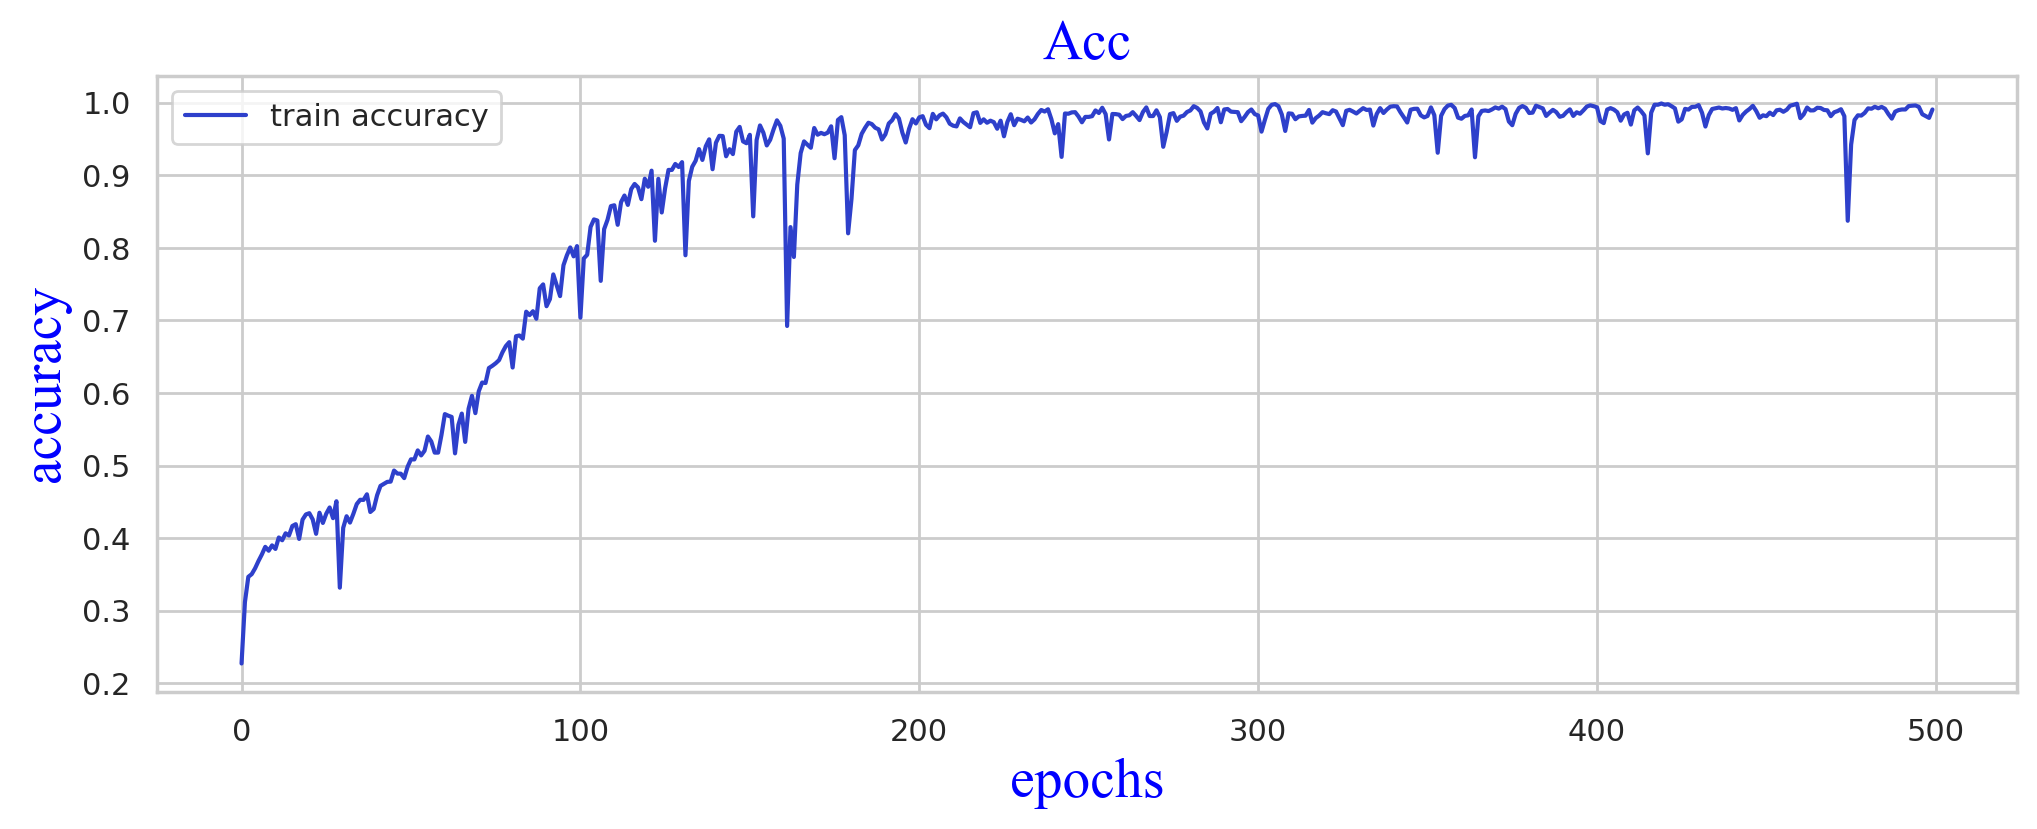

In [85]:
epochs = list(range(500))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

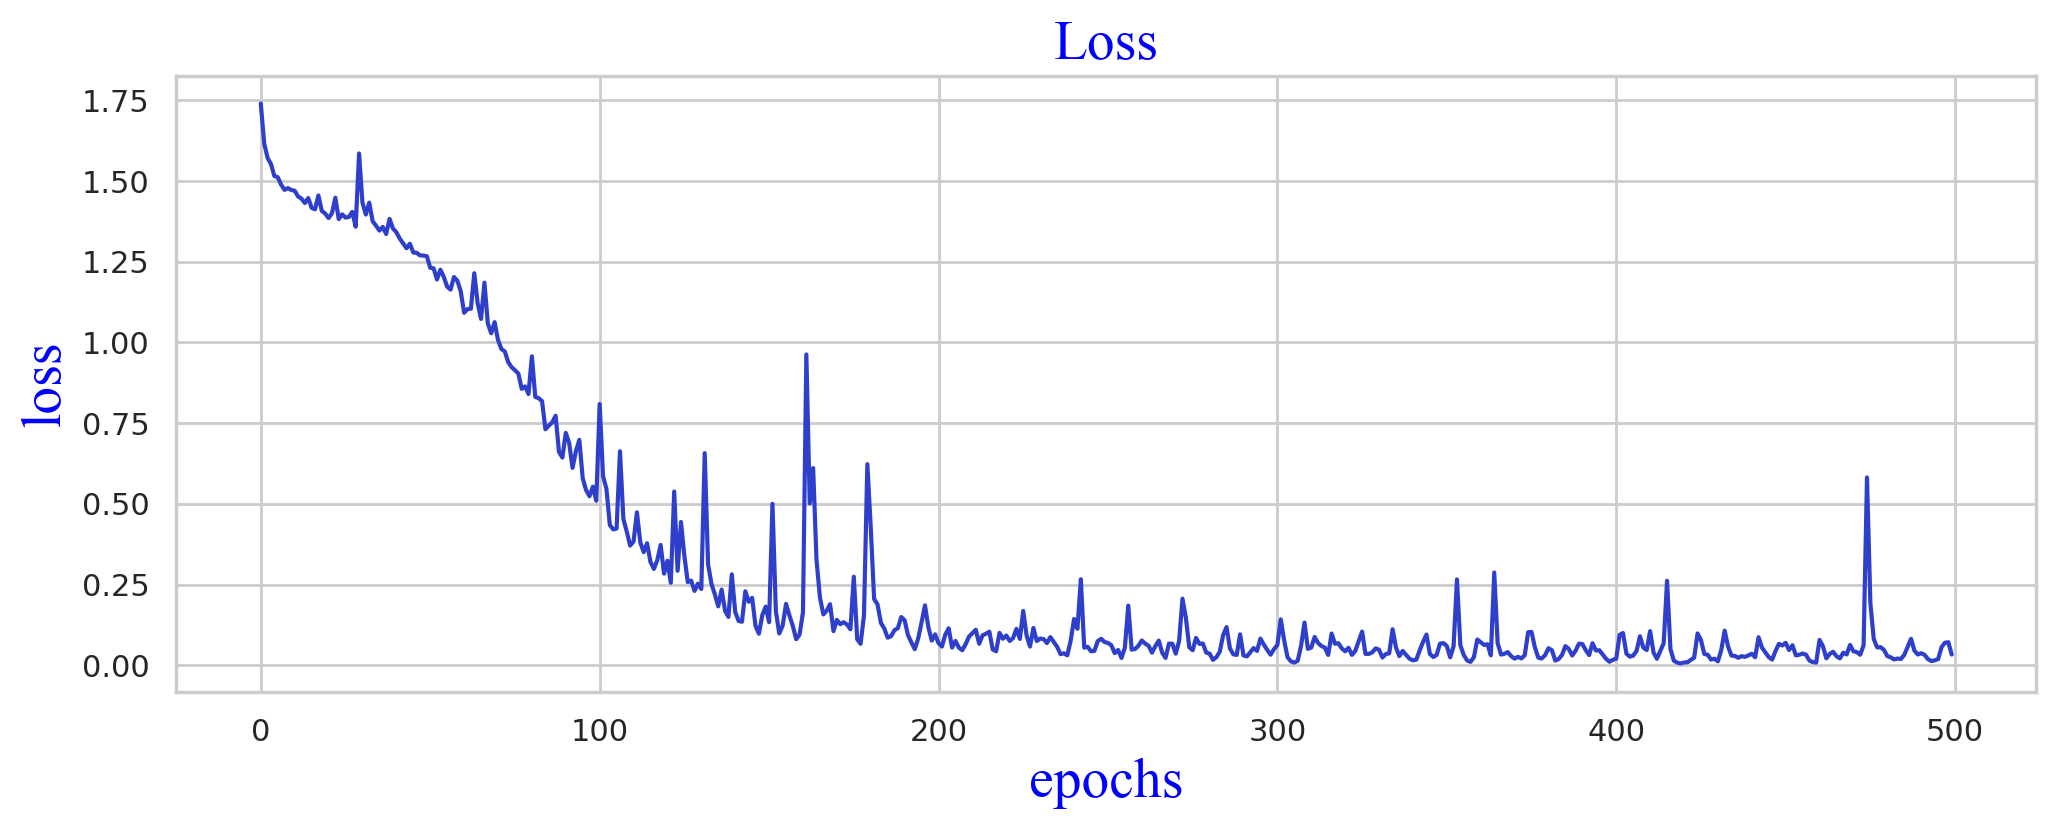

In [87]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()